In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

# Load data

In [2]:
engine1 = pd.read_csv("UIPA.HMD8310H.Engine1.csv")
engine2 = pd.read_csv("UIPA.HMD8310H.Engine2.csv")

/tmp/ipykernel_211424/1235946815.py:1: DtypeWarning: Columns (152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,38

In [3]:
engine1["battery_only"] = engine1["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)
engine2["battery_only"] = engine2["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)

In [4]:
merged_df = pd.merge(engine1[["aIEngineLoad", "time", "battery_only"]], engine2[["aIEngineLoad", "time"]], on='time', how='inner')
merged_df["total_load"] = merged_df["aIEngineLoad_x"] + merged_df["aIEngineLoad_y"]
merged_df_all_columns = pd.merge(engine1, engine2, on='time', how='inner')
merged_df_all_columns["total_load"] = merged_df_all_columns["aIEngineLoad_x"] + merged_df_all_columns["aIEngineLoad_y"]

In [5]:
mgo = pd.read_csv("RemoteLevelThing_HMD8310.csv")
mgo["total_vol"] = mgo["MGO_STOR_TK_C_CALC_VOL"] + mgo["MGO_STOR_TK_S_CALC_VOL"] + mgo["NO1_MGO_SERV_TK_CALC_VOL"] + mgo["NO2_MGO_SERV_TK_CALC_VOL"]

/tmp/ipykernel_211424/3850218066.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  mgo = pd.read_csv("RemoteLevelThing_HMD8310.csv")


In [6]:
engine_and_fuel_df = pd.merge(merged_df, mgo[["total_vol", "time"]], on='time', how='inner')
engine_and_fuel_df_all_columns = pd.merge(merged_df_all_columns, mgo[["total_vol", "time"]], on='time', how='inner')

# Find useful segments

In [7]:
numeric_columns = engine_and_fuel_df_all_columns.select_dtypes(include=['number'])
numeric_columns["total_vol_diff"] = numeric_columns["total_vol"].diff()
numeric_columns["total_vol_diff"].iloc[:-1] = numeric_columns["total_vol_diff"].iloc[1:].values
corr = numeric_columns.corr()

/tmp/ipykernel_211424/2805894286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_columns["total_vol_diff"].iloc[:-1] = numeric_columns["total_vol_diff"].iloc[1:].values


In [8]:
print(corr["total_vol_diff"].sort_values(ascending=False)[:5])
print(corr["total_vol_diff"].sort_values(ascending=True)[:5])

total_vol_diff                                  1.000000
aICyclicSlowTurningState_y                      0.008492
aICyclicSlowTurningState_x                      0.004630
aITimeRemainingForNextCyclicSlowTurningSec_x    0.003461
aIModbusHeartbeatCounter_y                      0.003421
Name: total_vol_diff, dtype: float64
total_vol                                      -0.051304
aITimeRemainingForNextCyclicSlowTurningMin_y   -0.017514
aIKnockKnockIntensityCylinderA07_y             -0.014379
aIDurationOffsetPilotInjectionCylinderA05_y    -0.004995
aIKnockKnockIntensityCylinderA07_x             -0.004850
Name: total_vol_diff, dtype: float64


In [9]:
fuel_noise_start_points = [1750, 10000, 29500, 35400, 85500]
fuel_noise_end_points = [9300, 17800, 32200, 48100, 88500]

segments = []

for noise_start_point, noise_end_point in zip(fuel_noise_start_points, fuel_noise_end_points):
    segment = engine_and_fuel_df_all_columns.loc[noise_start_point:noise_end_point].copy()
    segment.reset_index(drop=True, inplace=True)
    segments.append(segment)

In [10]:
for column in segments:
    try:
        segments[column] = pd.to_numeric(segments[column])
    except:
        pass

In [11]:
segment_columns = ['aIEngineLoadPercent_y','aIEngineLoad_y','aIAirTemperatureTCInlet_y','aIGRUEnclosurePressure_x','aIGasTemperature_y','aIPilotFOTemperatureEngineInlet_x','aIChargeAirPressureEngineInlet_y','aIGRUEnclosurePressure_y','aIGasPressureEngineInlet_y','aIPilotFOPressureEngineOutlet_y','aIKnockKnockIntensityCylinderA02_x','aIKnockKnockIntensityCylinderA01_y','total_load','aIPmaxCylinderA04_y','aIPilotFOPressureEngineOutlet_x','aIRUNHoursGAS_y','aIWasteGateValvePositionCommand_y','aIChargeAirSetpointBarMPa_y','aIKnockKnockIntensityCylinderA08_x', 'total_vol']

rolling_mean_segments = []
original_segments = []

for segment in segments:
    # Create a numerical index for grouping
    tmp = segment.select_dtypes(include=['number']).copy()
    # tmp = segment.copy()
    tmp.loc[:tmp.shape[0]-2, "total_vol_diff"] = tmp["total_vol"].diff().values[1:]
    rolling_mean = tmp.rolling(100).mean()
    # tmp['Group'] = np.arange(len(tmp)) // 5

    # # Compute the average of each group
    # tmp_average = tmp.groupby('Group').mean()

    # Optionally, you can drop the 'Group' column from the new DataFrame if it's no longer needed
    rolling_mean.dropna(inplace=True)
    rolling_mean.reset_index(drop=True, inplace=True)
    rolling_mean_segments.append(rolling_mean)
    tmp.reset_index(drop=True, inplace=True)
    original_segments.append(tmp)

In [12]:
monotonically_decreasing_segments = []
for segment in rolling_mean_segments:
    tmp = segment.copy()
    new_segment = pd.DataFrame(columns=tmp.columns)
    min_value = tmp.loc[0, "total_vol"]
    for idx, row in tmp.iterrows():
        if row["total_vol"] < min_value:
            new_segment.loc[idx] = row
            min_value = row["total_vol"]
    new_segment.reset_index(drop=True, inplace=True)
    monotonically_decreasing_segments.append(new_segment)

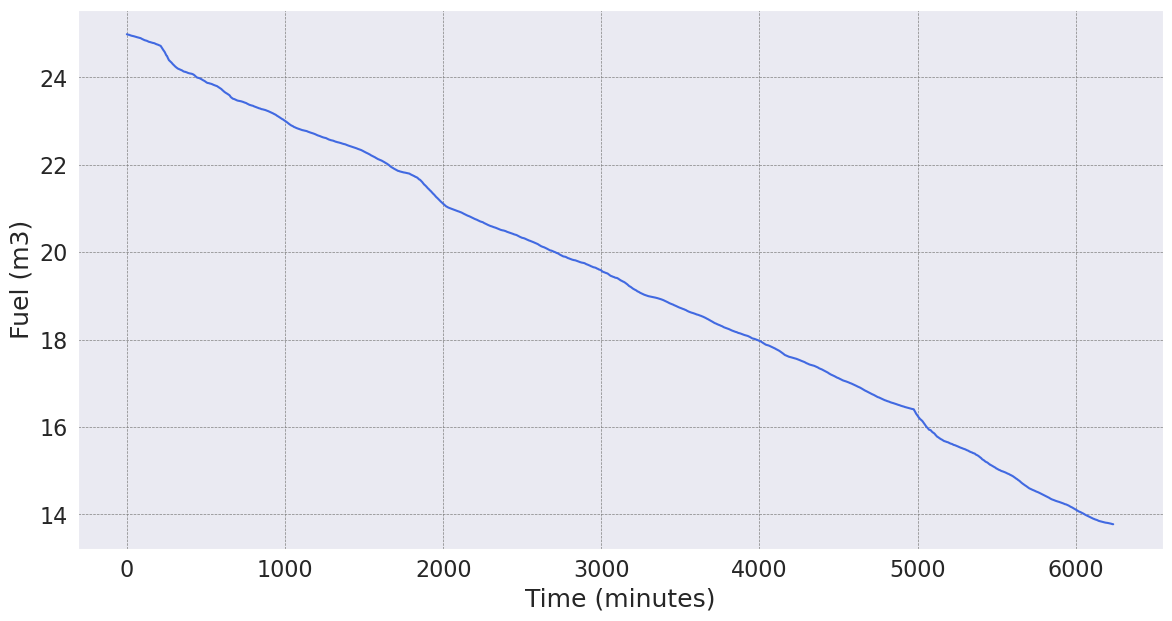

In [135]:
sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
sns.lineplot(monotonically_decreasing_segments[0]["total_vol"], color="royalblue")

# Customizing the plot
plt.xlabel('Time (minutes)', fontsize=18)
plt.ylabel('Fuel (m3)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Feature importance of numeric values

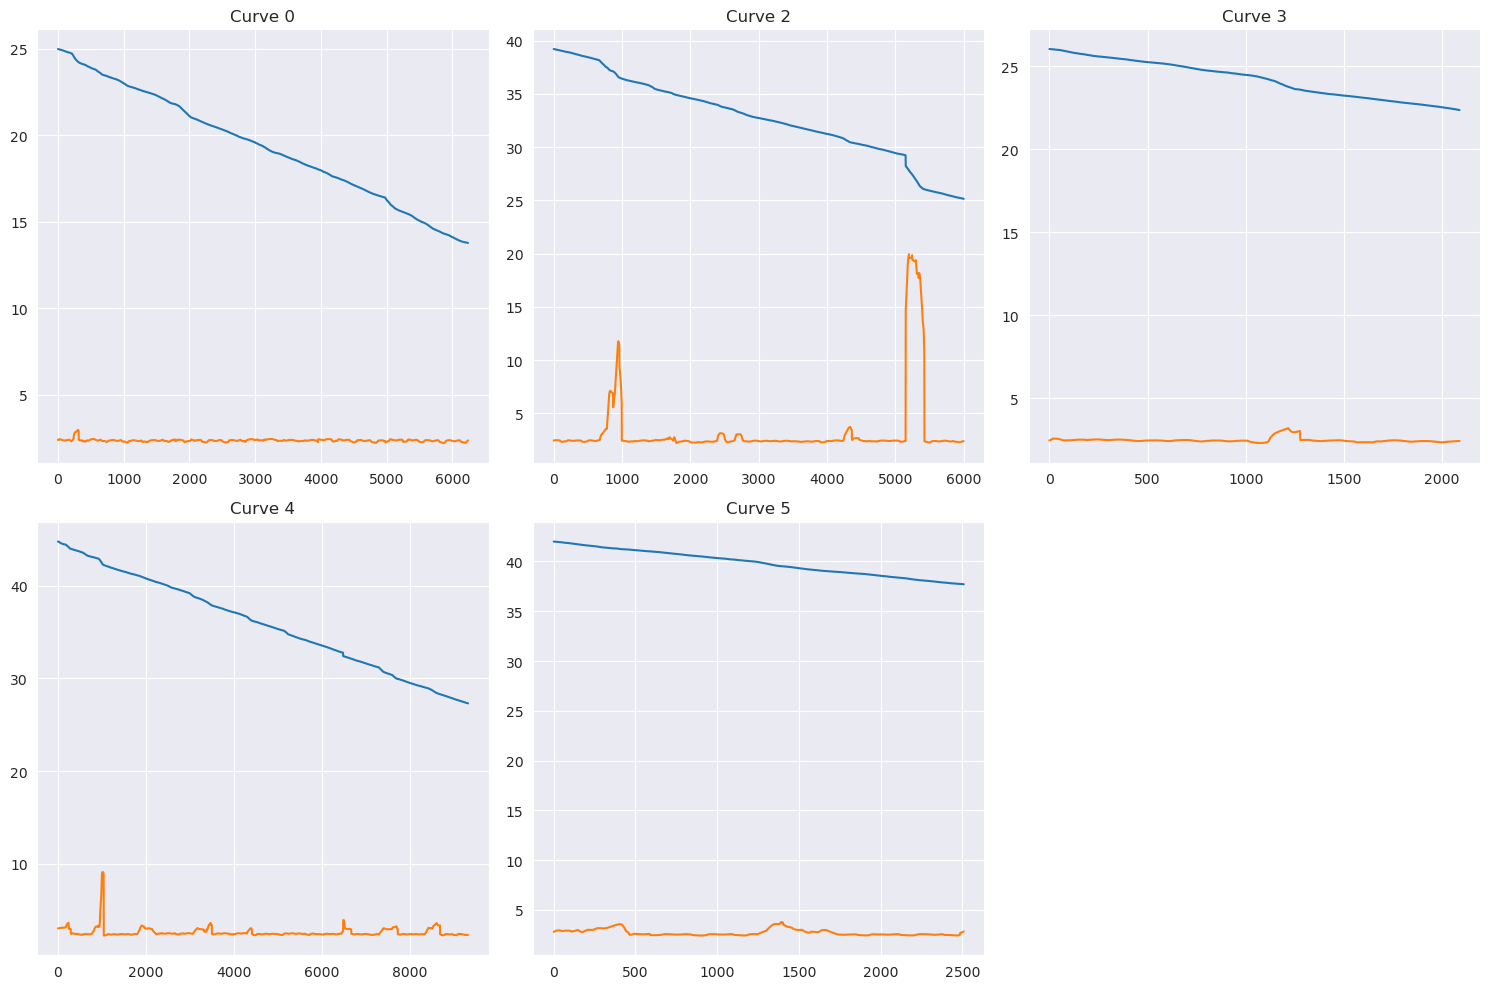

In [136]:
# Creating a 2x3 grid plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plotting in the first five subplots
axs[0, 0].plot(monotonically_decreasing_segments[0]["total_vol"])
axs[0, 0].plot(monotonically_decreasing_segments[0]["total_load"]/100)
axs[0, 0].set_title('Curve 0')

axs[0, 1].plot(monotonically_decreasing_segments[1]["total_vol"])
axs[0, 1].plot(monotonically_decreasing_segments[1]["total_load"]/100)
axs[0, 1].set_title('Curve 2')

axs[0, 2].plot(monotonically_decreasing_segments[2]["total_vol"])
axs[0, 2].plot(monotonically_decreasing_segments[2]["total_load"]/100)
axs[0, 2].set_title('Curve 3')

axs[1, 0].plot(monotonically_decreasing_segments[3]["total_vol"])
axs[1, 0].plot(monotonically_decreasing_segments[3]["total_load"]/100)
axs[1, 0].set_title('Curve 4')

axs[1, 1].plot(monotonically_decreasing_segments[4]["total_vol"])
axs[1, 1].plot(monotonically_decreasing_segments[4]["total_load"]/100)
axs[1, 1].set_title('Curve 5')

# Leaving the last plot empty
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

# .plot()
# (rolling_mean_segments[1]["total_load"]/100).plot()

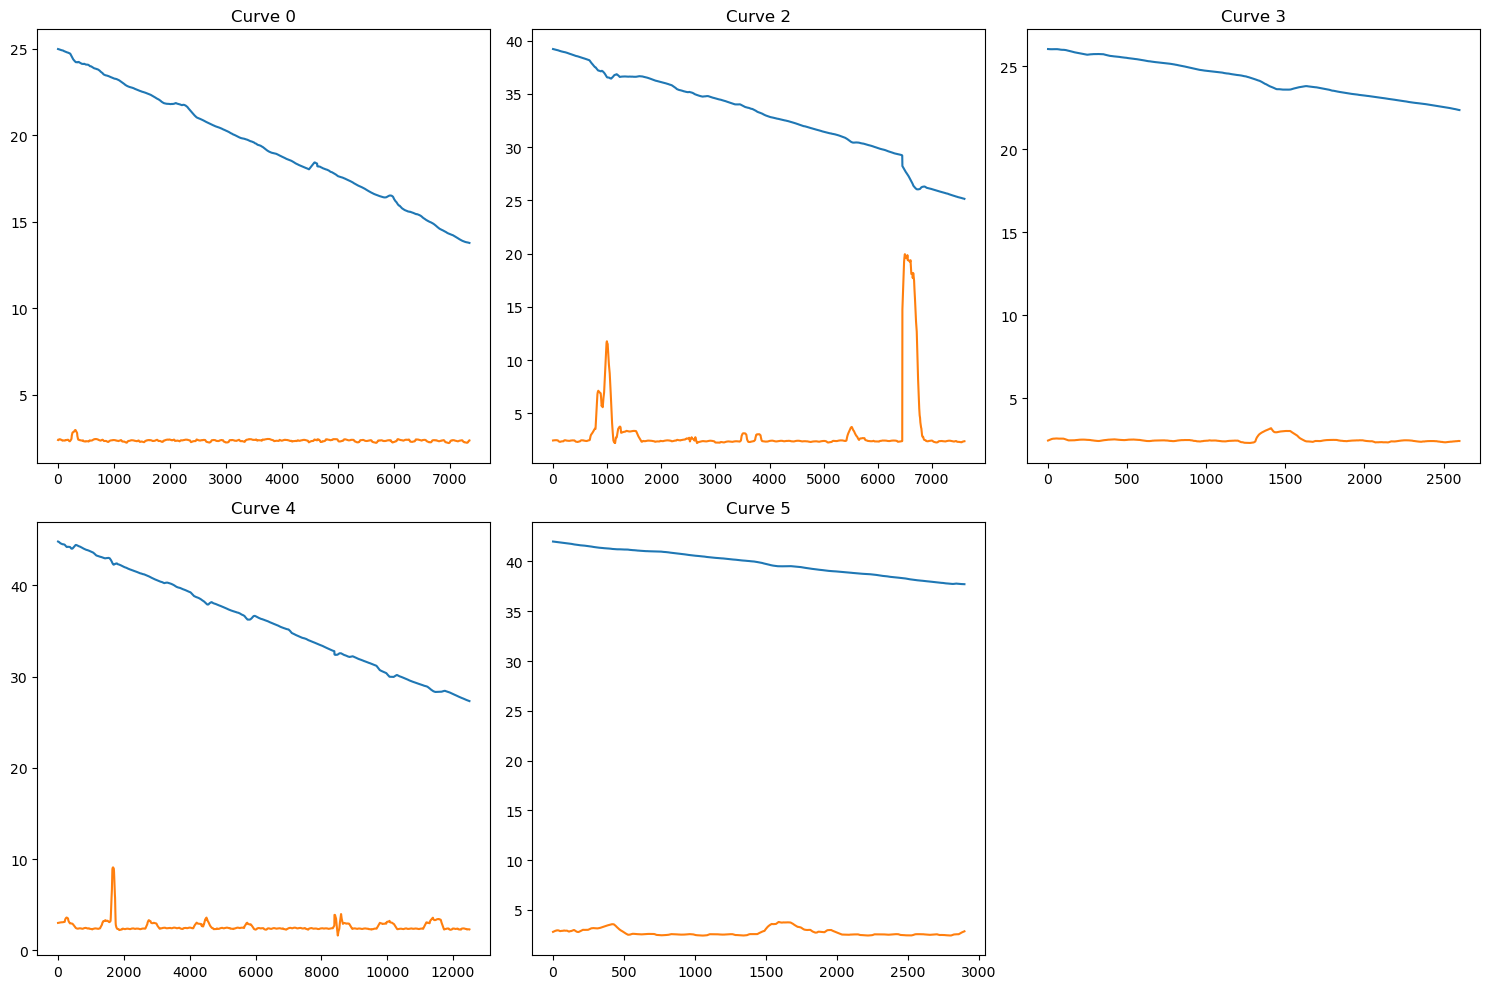

In [14]:
# Creating a 2x3 grid plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plotting in the first five subplots
axs[0, 0].plot(rolling_mean_segments[0]["total_vol"])
axs[0, 0].plot(rolling_mean_segments[0]["total_load"]/100)
axs[0, 0].set_title('Curve 0')

axs[0, 1].plot(rolling_mean_segments[1]["total_vol"])
axs[0, 1].plot(rolling_mean_segments[1]["total_load"]/100)
axs[0, 1].set_title('Curve 2')

axs[0, 2].plot(rolling_mean_segments[2]["total_vol"])
axs[0, 2].plot(rolling_mean_segments[2]["total_load"]/100)
axs[0, 2].set_title('Curve 3')

axs[1, 0].plot(rolling_mean_segments[3]["total_vol"])
axs[1, 0].plot(rolling_mean_segments[3]["total_load"]/100)
axs[1, 0].set_title('Curve 4')

axs[1, 1].plot(rolling_mean_segments[4]["total_vol"])
axs[1, 1].plot(rolling_mean_segments[4]["total_load"]/100)
axs[1, 1].set_title('Curve 5')

# Leaving the last plot empty
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

# .plot()
# (rolling_mean_segments[1]["total_load"]/100).plot()

## Numeric values by correlation

In [15]:
orig_corrs_df = pd.DataFrame(columns=["corr0", "corr1", "corr2", "corr3", "corr4"])
mono_corrs_df = pd.DataFrame(columns=["corr0", "corr1", "corr2", "corr3", "corr4"])
for i in range(5):
    orig_corrs_df[f"corr{i}"] = rolling_mean_segments[i].corr()["total_vol_diff"]
    mono_corrs_df[f"corr{i}"] = monotonically_decreasing_segments[i].corr()["total_vol_diff"]

In [16]:
orig_corrs_df.sort_values("corr0")[:10]

,corr0,corr1,corr2,corr3,corr4
aIKnockKnockIntensityCylinderA07_y,-0.246233,-0.342288,NaN,-0.048310,NaN
aIMainFOTemperatureFilterInlet_x,-0.207913,-0.054169,0.446545,0.043882,0.044472
aIMainFOTemperatureFilterInlet_y,-0.168522,-0.074371,0.253570,-0.080471,-0.075084
aIGasSupplyPressureFilterInlet_y,-0.134390,-0.051196,-0.104660,-0.077766,-0.057771
aIGasSupplyPressureFilterOutlet_y,-0.133962,-0.052002,-0.104315,-0.077675,-0.057366
aIGasSupplyPressureFilterInlet_x,-0.132042,-0.051681,-0.104448,-0.077521,-0.057552
aIGasSupplyPressureFilterOutlet_x,-0.129272,-0.051770,-0.104238,-0.077565,-0.058411
total_load,-0.121526,-0.571969,-0.059556,-0.084955,0.026259
aILOTemperatureEngineInlet_x,-0.075592,-0.086744,0.189303,0.064017,0.060604
aIAirTemperatureTCInlet_x,-0.069567,-0.008126,0.338457,0.160459,0.092117


In [17]:
# The monotonically decreasing values dataframe is better!
# We will use the corr
mono_corrs_df.sort_values("corr1", ascending=True)[:5]

,corr0,corr1,corr2,corr3,corr4
total_load,-0.217557,-0.733904,-0.467948,-0.379475,-0.121729
aIKnockKnockIntensityCylinderA09_y,NaN,-0.682839,NaN,-0.300169,NaN
aIGasPressureEngineInlet_x,0.044716,-0.665961,0.260389,-0.114966,0.012220
aIChargeAirPressureEngineInlet_x,0.083098,-0.643443,-0.079889,-0.149828,0.009226
aIEngineLoad_x,0.066771,-0.625164,NaN,-0.133232,0.005984


In [18]:
mono_corrs_df.describe()

,corr0,corr1,corr2,corr3,corr4
count,184.000000,218.000000,170.000000,239.000000,205.000000
mean,-0.019120,-0.183186,-0.043953,-0.048581,-0.004017
std,0.113638,0.254142,0.249704,0.124931,0.095673
min,-0.332670,-0.733904,-0.480340,-0.379475,-0.325782
25%,-0.075734,-0.309072,-0.229940,-0.089070,-0.035358
50%,-0.001775,-0.213683,-0.011905,-0.051122,-0.008380
75%,0.026437,-0.026228,0.133293,-0.001036,0.020935
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

In [20]:
# There are many only zero columns
monotonically_decreasing_segments[0].describe()

,Unnamed: 0_x,aIAirTemperatureTCInlet_x,aIBaseDurationGasAdmission_x,aIChargeAirPressureEngineInlet_x,aIChargeAirSetpointBarMPa_x,aIChargeAirTemperatureEngineInlet_x,aICounterStarts_x,aICounterStartsX10000_x,aICrankcasePressure_x,aICyclicSlowTurningResult_x,...,aITimingOffsetPilotInjectionCylinderA06_y,aITimingOffsetPilotInjectionCylinderA07_y,aITimingOffsetPilotInjectionCylinderA08_y,aITimingOffsetPilotInjectionCylinderA09_y,aIWasteGateValvePositionCommand_y,dateTime_y,battery_only_y,total_load,total_vol,total_vol_diff
count,6238.000000,6238.000000,6238.0,6238.000000,6238.000000,6238.000000,6238.000000,6238.0,6238.000000,6238.0,...,6238.0,6238.0,6238.0,6238.0,6238.000000,6.238000e+03,6238.0,6238.000000,6238.000000,6238.000000
mean,21382.949182,32.801941,0.0,1.410039,1.869954,43.071860,762.940192,0.0,1.055550,0.0,...,0.0,0.0,0.0,0.0,97.882013,1.685866e+12,0.0,234.963669,19.353199,-0.001767
std,2189.591040,1.831582,0.0,0.041896,0.085145,0.615334,0.234273,0.0,0.121758,0.0,...,0.0,0.0,0.0,0.0,12.123537,1.315381e+08,0.0,7.456973,3.169994,0.001132
min,17664.500000,29.675000,0.0,1.009700,0.989700,42.685000,762.000000,0.0,0.063000,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.685643e+12,0.0,220.130000,13.774350,-0.009650
25%,19397.750000,31.272500,0.0,1.409000,1.876600,42.982000,763.000000,0.0,1.031000,0.0,...,0.0,0.0,0.0,0.0,100.000000,1.685747e+12,0.0,231.730000,16.815012,-0.002250
50%,21296.000000,32.790000,0.0,1.416300,1.881700,43.002000,763.000000,0.0,1.064000,0.0,...,0.0,0.0,0.0,0.0,100.000000,1.685860e+12,0.0,235.230000,19.365125,-0.001650
75%,23289.250000,34.478750,0.0,1.422100,1.885700,43.023000,763.000000,0.0,1.098000,0.0,...,0.0,0.0,0.0,0.0,100.000000,1.685980e+12,0.0,237.770000,22.187750,-0.001050
max,25113.500000,36.551000,0.0,1.434100,1.895400,50.033000,763.000000,0.0,1.209000,0.0,...,0.0,0.0,0.0,0.0,100.000000,1.686090e+12,0.0,295.900000,24.985550,0.001700


In [21]:
scaled_segments = []
train_columns_list = []
ys = []
for segment in monotonically_decreasing_segments:
    # Drop all zero columns
    nonzero_columns = segment.loc[:, (segment!=0).any(axis=0)].copy()
    nonzero_columns.drop("total_vol_diff", inplace=True, axis=1)
    train_columns_list.append(nonzero_columns.columns)
    scaler = StandardScaler()
    scaled_segment = scaler.fit_transform(nonzero_columns)
    scaled_segments.append(scaled_segment)
    ys.append(segment["total_vol_diff"])

## Lasso regression

In [22]:
X = scaled_segments[3]
y = ys[3]
train_columns = train_columns_list[3]

In [23]:
alpha = [0.2, 0.25, 0.275, 0.3, 0.325, 0.35]

lasso_feature_coef_df = pd.DataFrame(np.zeros((len(train_columns), len(alpha))), index=train_columns, columns=alpha)
for a in alpha:
    lasso = Lasso(alpha=a)
    lasso.fit(X, y)
    
    lasso_feature_coef_df[a] = lasso.coef_

In [24]:
lasso_top10_features = lasso_feature_coef_df.reindex(index=lasso_feature_coef_df[0.30].abs().sort_values(ascending = False).index).head(10)

lasso_top10_features

,0.200,0.250,0.275,0.300,0.325,0.350
Unnamed: 0_x,0.0,0.0,0.0,0.0,0.0,0.0
aIExhaustGasTemperatureTCOutlet_y,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
aIFuelActuatorDemand_y,0.0,0.0,0.0,0.0,0.0,0.0
aIFuelModeActive_y,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
aIFuelModeApplied_y,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
aIFuelModeSelected_y,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
aIFuelTransferState_y,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
aIGRUControlAirPressure_y,0.0,0.0,0.0,0.0,0.0,0.0
aIGRUEnclosurePressure_y,0.0,0.0,0.0,0.0,0.0,0.0
aIGasFlow_y,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [25]:
selected_features_lasso = lasso_top10_features.index[:4].tolist()
print('Features of significant coefficient include: \n', selected_features_lasso)

Features of significant coefficient include: 
 ['Unnamed: 0_x', 'aIExhaustGasTemperatureTCOutlet_y', 'aIFuelActuatorDemand_y', 'aIFuelModeActive_y']


## RFR

In [26]:
rf = RandomForestRegressor(n_estimators=200, criterion='squared_error', max_features='sqrt')
rf.fit(X, y)

RandomForestRegressor(max_features='sqrt', n_estimators=200)

In [27]:
# Store the top 30 most important features based off rf regressor
rf_feature_importance_df = pd.DataFrame(rf.feature_importances_, index=train_columns, columns=['Importance_Value'])
rf_top30_features = rf_feature_importance_df.sort_values(by = ['Importance_Value'], ascending=False).head(30)

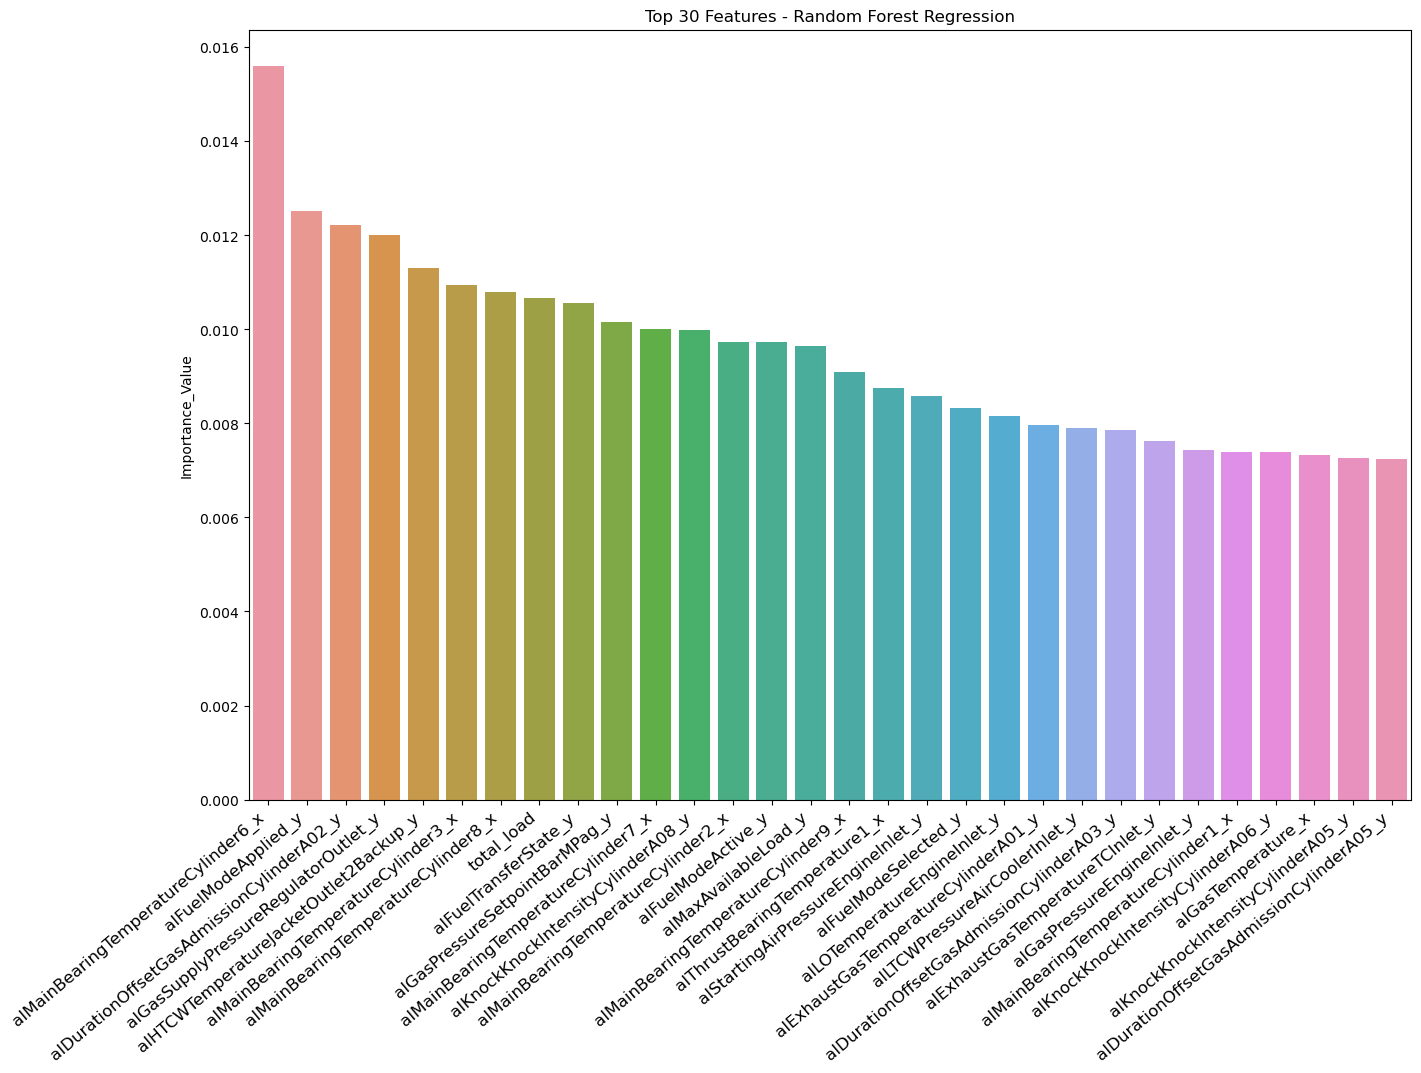

In [28]:
plt.figure(figsize=(15, 10))
ax0 = sns.barplot(x = rf_top30_features.index, y = 'Importance_Value', data=rf_top30_features)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize = 12, rotation=40, ha="right")
plt.title('Top 30 Features - Random Forest Regression')
plt.show()

In [29]:
selected_features_rf = rf_top30_features[rf_top30_features.Importance_Value >= 0.005].index.tolist()

print('Features of high importance value include: \n', selected_features_rf)

Features of high importance value include: 
 ['aIMainBearingTemperatureCylinder6_x', 'aIFuelModeApplied_y', 'aIDurationOffsetGasAdmissionCylinderA02_y', 'aIGasSupplyPressureRegulatorOutlet_y', 'aIHTCWTemperatureJacketOutlet2Backup_y', 'aIMainBearingTemperatureCylinder3_x', 'aIMainBearingTemperatureCylinder8_x', 'total_load', 'aIFuelTransferState_y', 'aIGasPressureSetpointBarMPag_y', 'aIMainBearingTemperatureCylinder7_x', 'aIKnockKnockIntensityCylinderA08_y', 'aIMainBearingTemperatureCylinder2_x', 'aIFuelModeActive_y', 'aIMaxAvailableLoad_y', 'aIMainBearingTemperatureCylinder9_x', 'aIThrustBearingTemperature1_x', 'aIStartingAirPressureEngineInlet_y', 'aIFuelModeSelected_y', 'aILOTemperatureEngineInlet_y', 'aIExhaustGasTemperatureCylinderA01_y', 'aILTCWPressureAirCoolerInlet_y', 'aIDurationOffsetGasAdmissionCylinderA03_y', 'aIExhaustGasTemperatureTCInlet_y', 'aIGasPressureEngineInlet_y', 'aIMainBearingTemperatureCylinder1_x', 'aIKnockKnockIntensityCylinderA06_y', 'aIGasTemperature_x', 'a

## Gradient tree boosting regression

In [30]:
gbr = GradientBoostingRegressor(loss='squared_error', n_estimators=200, learning_rate=0.1, 
                                max_depth=8, max_features = 'sqrt',  
                                min_samples_split = 500, random_state=0)
gbr.fit(X, y)

GradientBoostingRegressor(max_depth=8, max_features='sqrt',
                          min_samples_split=500, n_estimators=200,
                          random_state=0)

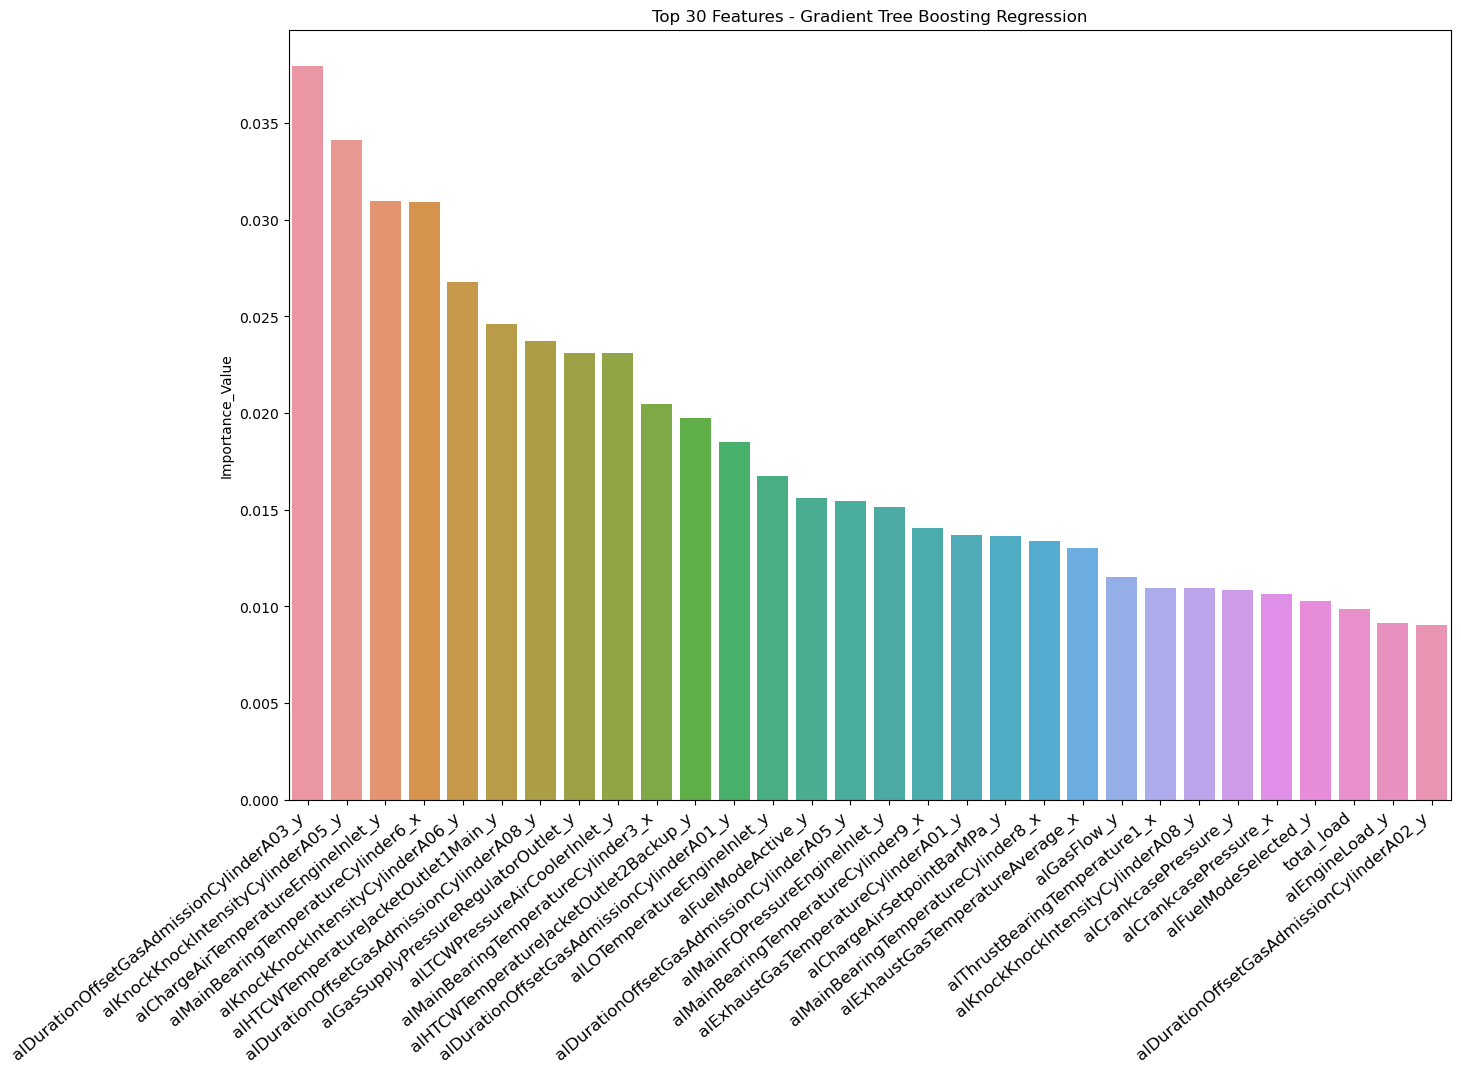

In [31]:
plt.figure(figsize=(15, 10))
gbr_feature_importance_df = pd.DataFrame(gbr.feature_importances_, index=train_columns, columns=['Importance_Value'])
gbr_top30_features = gbr_feature_importance_df.sort_values(by = ['Importance_Value'], ascending=False).head(30)

ax1 = sns.barplot(x = gbr_top30_features.index, y = 'Importance_Value', data=gbr_top30_features)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize = 12, rotation=40, ha="right")
plt.title('Top 30 Features - Gradient Tree Boosting Regression')
plt.show()

In [32]:
selected_features_gbr = gbr_top30_features[gbr_top30_features.Importance_Value >= 0.005].index.tolist()

print('Features of high importance value include: \n', selected_features_gbr)

Features of high importance value include: 
 ['aIDurationOffsetGasAdmissionCylinderA03_y', 'aIKnockKnockIntensityCylinderA05_y', 'aIChargeAirTemperatureEngineInlet_y', 'aIMainBearingTemperatureCylinder6_x', 'aIKnockKnockIntensityCylinderA06_y', 'aIHTCWTemperatureJacketOutlet1Main_y', 'aIDurationOffsetGasAdmissionCylinderA08_y', 'aIGasSupplyPressureRegulatorOutlet_y', 'aILTCWPressureAirCoolerInlet_y', 'aIMainBearingTemperatureCylinder3_x', 'aIHTCWTemperatureJacketOutlet2Backup_y', 'aIDurationOffsetGasAdmissionCylinderA01_y', 'aILOTemperatureEngineInlet_y', 'aIFuelModeActive_y', 'aIDurationOffsetGasAdmissionCylinderA05_y', 'aIMainFOPressureEngineInlet_y', 'aIMainBearingTemperatureCylinder9_x', 'aIExhaustGasTemperatureCylinderA01_y', 'aIChargeAirSetpointBarMPa_y', 'aIMainBearingTemperatureCylinder8_x', 'aIExhaustGasTemperatureAverage_x', 'aIGasFlow_y', 'aIThrustBearingTemperature1_x', 'aIKnockKnockIntensityCylinderA08_y', 'aICrankcasePressure_y', 'aICrankcasePressure_x', 'aIFuelModeSelect

In [33]:
selected_features_combined = set(selected_features_rf+selected_features_gbr)

print('Selected features among combined variables include: \n', selected_features_combined)

Selected features among combined variables include: 
 {'aIMainBearingTemperatureCylinder1_x', 'aIEngineLoad_y', 'aIGasSupplyPressureRegulatorOutlet_y', 'aIHTCWTemperatureJacketOutlet2Backup_y', 'aIFuelModeSelected_y', 'aIMainBearingTemperatureCylinder8_x', 'aIGasFlow_y', 'aILTCWPressureAirCoolerInlet_y', 'aIChargeAirTemperatureEngineInlet_y', 'total_load', 'aIMainBearingTemperatureCylinder6_x', 'aIExhaustGasTemperatureCylinderA01_y', 'aIMaxAvailableLoad_y', 'aIKnockKnockIntensityCylinderA05_y', 'aIExhaustGasTemperatureTCInlet_y', 'aIDurationOffsetGasAdmissionCylinderA05_y', 'aIStartingAirPressureEngineInlet_y', 'aIDurationOffsetGasAdmissionCylinderA02_y', 'aICrankcasePressure_x', 'aIGasTemperature_x', 'aIGasPressureSetpointBarMPag_y', 'aIChargeAirSetpointBarMPa_y', 'aIMainBearingTemperatureCylinder7_x', 'aIHTCWTemperatureJacketOutlet1Main_y', 'aIFuelModeApplied_y', 'aIMainBearingTemperatureCylinder3_x', 'aIThrustBearingTemperature1_x', 'aILOTemperatureEngineInlet_y', 'aIDurationOffsetG

## Combine RFR and GTBR

In [34]:
segment_idxs = list(range(len(scaled_segments)))
selected_features_continuous_list = []

for segment_idx in segment_idxs:
    X = scaled_segments[segment_idx]
    y = ys[segment_idx]
    train_columns = train_columns_list[segment_idx]
    
    rf = RandomForestRegressor(n_estimators=200, criterion='squared_error', max_features='sqrt')
    rf.fit(X, y)
    # Store the top 30 most important features based off rf regressor
    rf_feature_importance_df = pd.DataFrame(rf.feature_importances_, index=train_columns, columns=['Importance_Value'])
    rf_top30_features = rf_feature_importance_df.sort_values(by = ['Importance_Value'], ascending=False).head(30)
    selected_features_rf = rf_top30_features[rf_top30_features.Importance_Value >= 0.005].index.tolist()

    gbr = GradientBoostingRegressor(loss='squared_error', n_estimators=200, learning_rate=0.1, 
                                    max_depth=8, max_features = 'sqrt',  
                                    min_samples_split = 500, random_state=0)
    gbr.fit(X, y)
    gbr_feature_importance_df = pd.DataFrame(gbr.feature_importances_, index=train_columns, columns=['Importance_Value'])
    gbr_top30_features = gbr_feature_importance_df.sort_values(by = ['Importance_Value'], ascending=False).head(30)
    selected_features_gbr = gbr_top30_features[gbr_top30_features.Importance_Value >= 0.005].index.tolist()
    selected_features_continuous = list(set(selected_features_rf+selected_features_gbr))
    selected_features_continuous_list.append(selected_features_continuous)

In [139]:
selected_features_continuous_list[2]

['aIMainBearingTemperatureCylinder1_x',
 'aIMainBearingTemperatureCylinder8_x',
 'aIPilotFOPressureFilterInlet_x',
 'aIChargeAirTemperatureEngineInlet_y',
 'aIMainBearingTemperatureCylinder5_x',
 'aIMainFOPressureFilterInlet_y',
 'total_load',
 'aIPilotFOPressureEngineInlet_y',
 'aIExhaustGasTemperatureCylinderA01_y',
 'aIGasTemperature_y',
 'aIMainBearingTemperatureCylinder4_x',
 'aIChargeAirPressureEngineInlet_y',
 'aIExhaustGasTemperatureCylinderA01_x',
 'aIFuelActuatorDemand_y',
 'aILOTemperatureTCOutlet_y',
 'aILOPressureEngineInlet2Backup_y',
 'aIPmaxCylinderA03_y',
 'aIEngineLoadPercent_y',
 'aIPilotFOPressureControl_y',
 'aIPmaxCylinderA05_y',
 'aIGasTemperature_x',
 'aIPilotFOPressureFilterInlet_y',
 'aIMainBearingTemperatureCylinder7_x',
 'aIInstrumentAirPressure_x',
 'aIExhaustGasTemperatureCylinderA09_y',
 'aIAirTemperatureTCInlet_y',
 'aILOTemperatureEngineInlet_x',
 'aIExhaustGasTemperatureCylinderA05_y',
 'aIGasSupplyPressureFilterOutlet_x',
 'aIStartingAirPressureEngine

# Feature importance of categorical values

## Categorical values by anova

In [35]:
bool_data_segments = []
original_segments = []

for segment in segments:
    # Create a numerical index for grouping
    numeric_data = segment.select_dtypes(include=['number']).copy()
    mask = segments[0].columns.str.startswith("dI")
    bool_columns = segments[0].columns[mask]
    bool_data = segment.loc[:, bool_columns]
    numeric_data.loc[:numeric_data.shape[0]-2, "total_vol_diff"] = numeric_data["total_vol"].diff().values[1:]

    rolling_mean = numeric_data.rolling(100).mean()
    rolling_mean.dropna(inplace=True)

    # Find monotonically decreasing segment
    tmp = rolling_mean.copy()
    mono_dec_new_segment = pd.DataFrame(columns=tmp.columns)
    min_value = tmp.loc[tmp.index[0], "total_vol"]
    for idx, row in tmp.iterrows():
        if row["total_vol"] < min_value:
            mono_dec_new_segment.loc[idx] = row
            min_value = row["total_vol"]

    bool_data = bool_data.loc[mono_dec_new_segment.index, :]
    bool_data.dropna(inplace=True)
    bool_data = bool_data.astype(int)
    bool_data["total_vol_diff"] = mono_dec_new_segment["total_vol_diff"]
    bool_data.reset_index(drop=True, inplace=True)
    bool_data_segments.append(bool_data)

In [36]:
bool_data_segments[0]["total_vol_diff"]

0      -0.00130
1      -0.00160
2      -0.00115
3      -0.00065
4      -0.00145
         ...   
4052   -0.00110
4053   -0.00005
4054   -0.00045
4055    0.00010
4056   -0.00065
Name: total_vol_diff, Length: 4057, dtype: float64

In [37]:
# Remove bool data that is all false or all true
count_nonzero_list = []
valid_bool_data_list = []
for bool_data in bool_data_segments:
    count_nonzero = pd.DataFrame(data = np.zeros((2, len(bool_data_segments[0].columns))), index=['zero', 'nonzero'], columns=bool_data_segments[0].columns)
    n_rows = len(bool_data)
    for i in bool_data.columns:
        try:
            n_zero = bool_data[i].value_counts()[0]
            n_nonzero = n_rows - n_zero
            count_nonzero[i].iloc[0] = n_zero
            count_nonzero[i].iloc[1] = n_nonzero
        except:
            pass
    mask = (count_nonzero.loc["nonzero"]!=0) & (count_nonzero.loc["zero"]!=0)
    nonzero_columns = count_nonzero.loc["nonzero"][mask].index
    valid_bool_data_list.append(bool_data[nonzero_columns])

In [38]:
# Using ANOVA

import pandas as pd
import scipy.stats as stats

# Sample DataFrame (replace with your DataFrame)
# df = pd.read_csv('your_data.csv')

# Function to perform ANOVA and return the p-value
def calculate_anova(df, column, dependent_variable):
    groups = [group.dropna() for name, group in df.groupby(column)[dependent_variable]]
    if len(groups) < 2 or any(len(group) < 2 for group in groups):
        # Skip categories with less than two groups or any group with less than two observations
        return None
    f_val, p_val = stats.f_oneway(*groups)
    return p_val

def make_results_df(bool_data, idx):
    categorical_columns = bool_data.columns[:-1]
    dependent_variable = bool_data.columns[-1]
    anova_df = pd.DataFrame(index=categorical_columns)
    # Calculating p-values for each categorical variable
    p_values = {column: calculate_anova(bool_data, column, dependent_variable) for column in categorical_columns}

    # Sorting variables based on p-value
    sorted_variables = sorted({k: v for k, v in p_values.items() if v is not None}.items(), key=lambda x: x[1])
    sorted_columns = [tup[0] for tup in sorted_variables]
    sorted_p_values = [tup[1] for tup in sorted_variables]
    anova_df.loc[sorted_columns, f"segment{idx}"] = sorted_p_values
    anova_df.dropna(inplace=True)
    anova_df = anova_df.sort_values(f"segment{idx}")
    return anova_df

anova_dfs = []
for i in range(len(valid_bool_data_list)):
    bool_data = valid_bool_data_list[i]
    anova_dfs.append(make_results_df(bool_data, i))

In [39]:
# Using f-regression
from sklearn.feature_selection import f_regression

def make_results_df(bool_data):
    categorical_columns = bool_data.columns[:-1]
    dependent_variable = bool_data.columns[-1]
    results_df = pd.DataFrame(index=categorical_columns)
    f, p_val = f_regression(bool_data[categorical_columns],bool_data[dependent_variable])
    results_df.loc[categorical_columns, "f-statistic"] = f
    results_df.loc[categorical_columns, "p-value"] = p_val
    return results_df

results_df_list = []
for i in range(len(valid_bool_data_list)):
    bool_data = valid_bool_data_list[i]
    results_df_list.append(make_results_df(bool_data))

In [40]:
results_df_list[0].sort_values("p-value")[:10]

,f-statistic,p-value
dIGeneratorCBIsClosedEvent_y,639.499347,3.839819e-131
dIDegassingValveACLOSEDPositionFeedbackEvent_y,493.449492,2.902838e-103
dIEnableActuatorEvent_y,492.973510,3.590531e-103
dIEngineIsRunningEvent_y,489.125920,2.004084e-102
dIReadyToStartEvent_y,465.650364,7.450119e-98
dIEngineStoppedEvent_y,465.650364,7.450119e-98
dIGeneratorCBIsClosedEvent_x,128.914931,1.961098e-29
dIDegassingValveACLOSEDPositionFeedbackEvent_x,126.761649,5.614085e-29
dIEnableActuatorEvent_x,126.761649,5.614085e-29
dIPilotFuelOilInjectionTestResult02Event_x,122.984689,3.557988e-28


## Categorical values by mutual information selection

In [41]:
from sklearn.feature_selection import mutual_info_regression

In [42]:
mi_df_list = []

for i in range(len(valid_bool_data_list)):
    print(f"Starting for index {i}")
    bool_data = valid_bool_data_list[i]
    target = bool_data["total_vol_diff"]
    mi = mutual_info_regression(bool_data, target, discrete_features = True, 
                                n_neighbors=5, copy=True, random_state=None)
    mi_df = pd.DataFrame(mi, index = bool_data.columns, columns = ['mutual_information'])
    mi_df_list.append(mi_df)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4faa4e0ee0>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Starting for index 0


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4f8d406560>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Starting for index 1


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fa9a39b40>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Starting for index 2


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4faa4e0ee0>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Starting for index 3


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4faa4e0ee0>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Starting for index 4


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4f8d405e10>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Text(0.5, 1.0, 'Top 10 Categorical Features - Mutual Information Regression - Discrete Features')

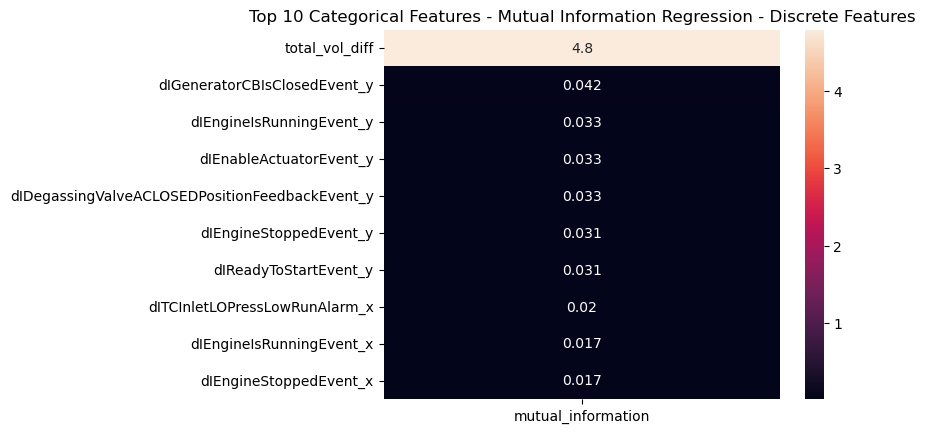

In [43]:
mi_top10_features = mi_df_list[0].sort_values(by='mutual_information', ascending=False).head(10)
sns.heatmap(data=mi_top10_features, annot=True)
plt.title('Top 10 Categorical Features - Mutual Information Regression - Discrete Features')

## Categorical values by RandomForestRegressor

In [44]:
from sklearn.ensemble import RandomForestRegressor
rf_df_list = []
for i in range(len(valid_bool_data_list)):
    print(f"Starting for index {i}")
    bool_data = valid_bool_data_list[i]
    target = bool_data["total_vol_diff"]
    rf_cat = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_features='sqrt')
    rf_cat.fit(bool_data, target)
    rf_cat_feature_importance_df = pd.DataFrame(rf_cat.feature_importances_, bool_data.columns, columns=['Importance_Value'])
    rf_df_list.append(rf_cat_feature_importance_df)

Starting for index 0
Starting for index 1
Starting for index 2
Starting for index 3
Starting for index 4


Text(0.5, 1.0, 'Top 10 Categorical Features - Random Forest - Feature Importance Value')

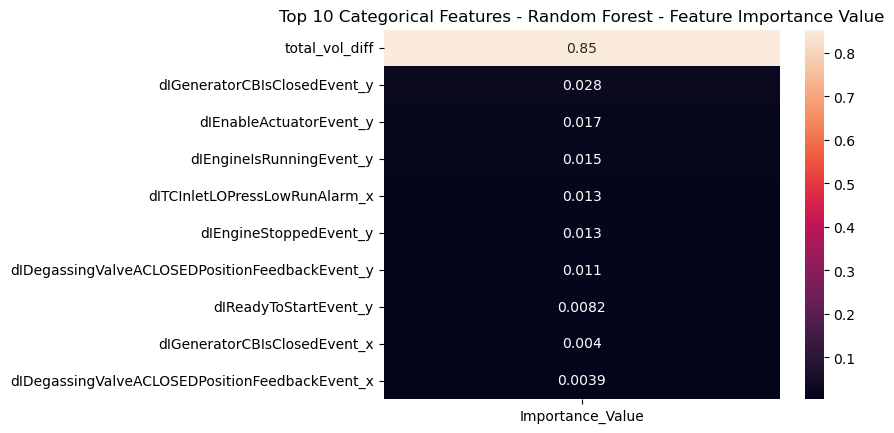

In [45]:
rf_cat_top10_features = rf_df_list[0].sort_values(by = ['Importance_Value'], ascending=False).head(10)
sns.heatmap(data = rf_cat_top10_features, annot=True )
plt.title('Top 10 Categorical Features - Random Forest - Feature Importance Value')

## Compare the methods results

In [46]:
all_dfs_results_list = []
for i in range(5):
    all_dfs_results = pd.DataFrame(index=results_df_list[i].index)
    all_dfs_results.loc[results_df_list[i].index, "p-value"] = results_df_list[i]["p-value"]
    mi_data = mi_df_list[i].drop("total_vol_diff")
    all_dfs_results.loc[mi_data.index, "mi"] = mi_data["mutual_information"]
    rf_data = rf_df_list[i].drop("total_vol_diff")
    all_dfs_results.loc[rf_data.index, "iv"] = rf_data["Importance_Value"]
    all_dfs_results_list.append(all_dfs_results)
# mi_df_list[0].sort_values(by='mutual_information', ascending=False).head(10)

In [47]:
print(all_dfs_results_list[0].sort_values("p-value")["p-value"][:10])
print(all_dfs_results_list[0].sort_values("mi", ascending=False)["mi"][:10])
print(all_dfs_results_list[0].sort_values("iv", ascending=False)["iv"][:10])

dIGeneratorCBIsClosedEvent_y                      3.839819e-131
dIDegassingValveACLOSEDPositionFeedbackEvent_y    2.902838e-103
dIEnableActuatorEvent_y                           3.590531e-103
dIEngineIsRunningEvent_y                          2.004084e-102
dIReadyToStartEvent_y                              7.450119e-98
dIEngineStoppedEvent_y                             7.450119e-98
dIGeneratorCBIsClosedEvent_x                       1.961098e-29
dIDegassingValveACLOSEDPositionFeedbackEvent_x     5.614085e-29
dIEnableActuatorEvent_x                            5.614085e-29
dIPilotFuelOilInjectionTestResult02Event_x         3.557988e-28
Name: p-value, dtype: float64
dIGeneratorCBIsClosedEvent_y                      0.041653
dIEngineIsRunningEvent_y                          0.033307
dIEnableActuatorEvent_y                           0.033144
dIDegassingValveACLOSEDPositionFeedbackEvent_y    0.032800
dIReadyToStartEvent_y                             0.031140
dIEngineStoppedEvent_y             

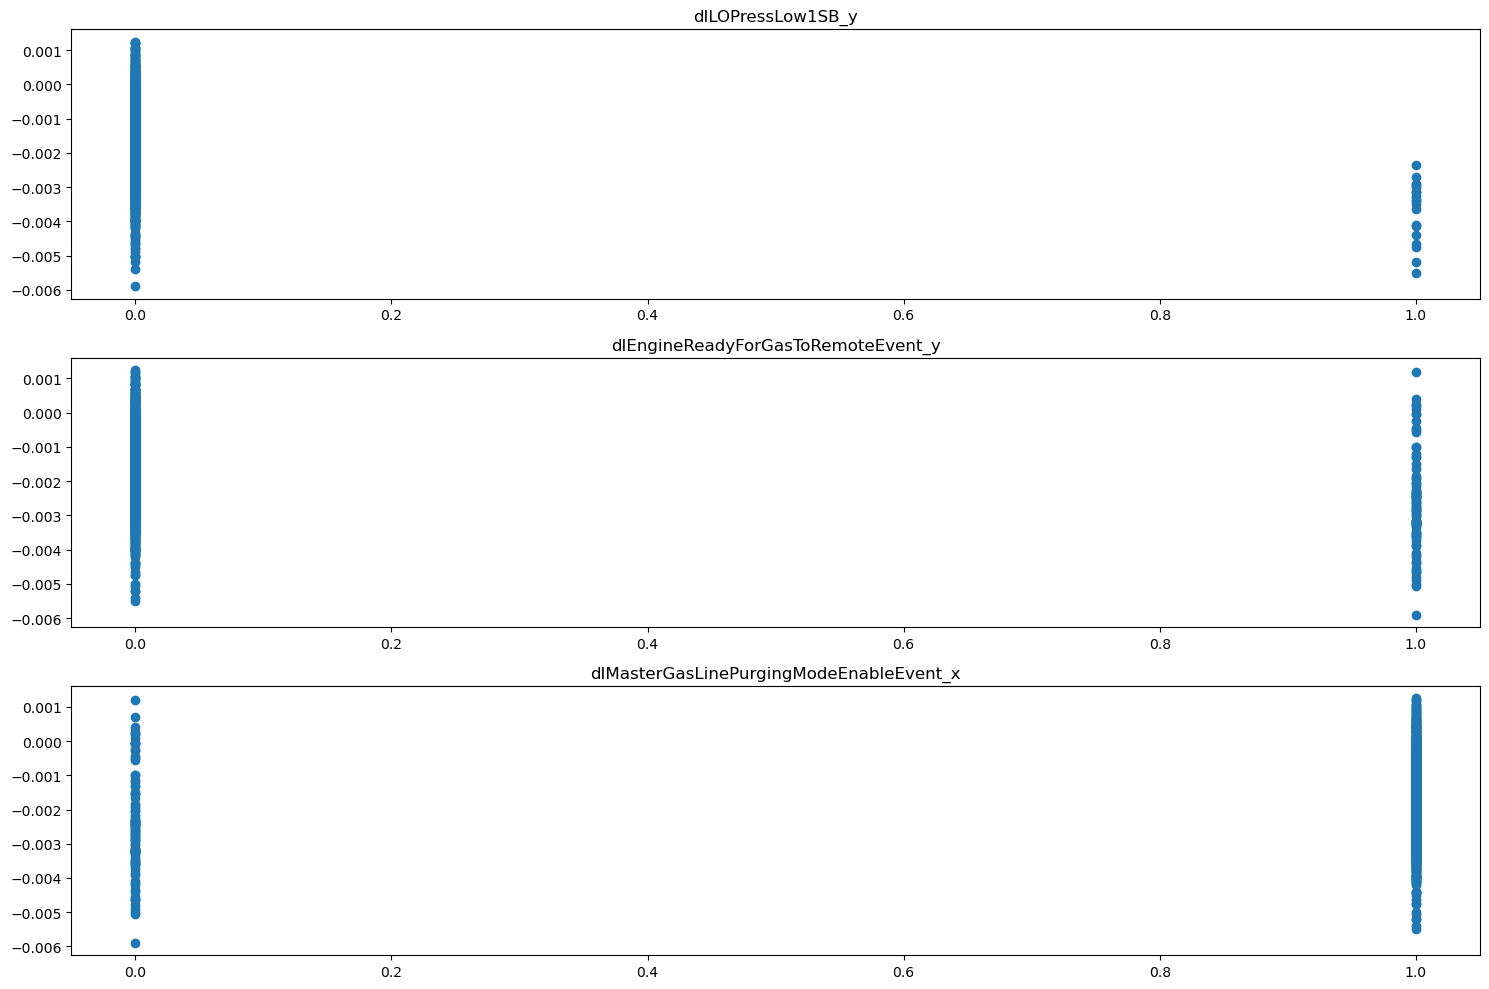

In [48]:
data_idx = 4
# selected_categorical_variables = list(all_dfs_results_list[data_idx].sort_values("p-value")["p-value"][:3].index)
selected_categorical_variables = list(all_dfs_results_list[data_idx].sort_values("iv", ascending=False)["iv"][:3].index)

bool_data = valid_bool_data_list[data_idx]
target = bool_data["total_vol_diff"]
describe_list = []

num_subplots = 3

# Create a 3x1 grid of subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(15, 10))

# Iterating over the grid
for i in range(num_subplots):
    var = selected_categorical_variables[i]
    axs[i].scatter(bool_data[var], target)
    axs[i].set_title(f"{var}")
    target0 = bool_data.loc[bool_data[var]==0, "total_vol_diff"]
    target1 = bool_data.loc[bool_data[var]==1, "total_vol_diff"]
    describe_list.append((target0.describe(), target1.describe()))
    
# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [49]:
describe_list[2]

(count    96.000000
 mean     -0.002479
 std       0.001498
 min      -0.005900
 25%      -0.003375
 50%      -0.002625
 75%      -0.001550
 max       0.001200
 Name: total_vol_diff, dtype: float64,
 count    2414.000000
 mean       -0.001631
 std         0.000924
 min        -0.005500
 25%        -0.002200
 50%        -0.001600
 75%        -0.001050
 max         0.001250
 Name: total_vol_diff, dtype: float64)

# Predicting the fuel consumption

## Using only continuous values

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.svm import SVR


# Define the Neural Network
class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, 50)  # Increased number of neurons
        self.bn1 = nn.BatchNorm1d(50)           # Batch normalization
        self.dropout1 = nn.Dropout(0.2)         # Dropout
        self.fc2 = nn.Linear(50, 50)            # 50 inputs, 50 outputs
        self.bn2 = nn.BatchNorm1d(50)           # Batch normalization
        self.dropout2 = nn.Dropout(0.2)         # Dropout
        self.fc3 = nn.Linear(50, 1)             # 50 inputs, 1 output

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

def net_pipeline(X_train, y_train, X_test, y_test, epochs):
    net = Net(X_train.shape[1])

    # Define the Loss Function and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Example Data (you will replace this with your actual data)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convert X to a PyTorch tensor
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Convert y to a PyTorch tensor
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convert X to a PyTorch tensor
    inputs = X_train_tensor
    targets = y_train_tensor

    # Training the Network
    for epoch in range(epochs):  # number of times to loop over the dataset
        optimizer.zero_grad()   # zero the parameter gradients
        outputs = net(inputs)   # forward pass
        loss = criterion(outputs, targets) # calculate the loss
        loss.backward()         # backward pass
        optimizer.step()        # optimize

        if epoch % 10 == 0:    # print every 100 epochs
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    with torch.no_grad():
        test_input = X_test_tensor # Example voltage input
        predicted = net(test_input)
        mae = mean_absolute_error(y_test, predicted)
    return mae

In [164]:
from itertools import product

# We will use only the monotonically decreasing segments cuz increasing fuel values don't make sense
segment_idxs = list(range(len(scaled_segments)))
feat_sel_methods = ["corr", "rfr", "gbr", "combined"]
parameters = list(product(segment_idxs, feat_sel_methods))
topk = 15

lgbm_mae_df = pd.DataFrame(index=segment_idxs)
xgb_mae_df = pd.DataFrame(index=segment_idxs)
rf_mae_df = pd.DataFrame(index=segment_idxs)
svr_mae_df = pd.DataFrame(index=segment_idxs)
net_mae_df = pd.DataFrame(index=segment_idxs)
ens_mae_df = pd.DataFrame(index=segment_idxs)
ens_pred_list = []

for segment_idx, feat_sel_method in parameters:
    if (feat_sel_method=="corr"):
        corr = mono_corrs_df.loc[:, f"corr{segment_idx}"]
        selected_negative_features = list(corr.sort_values()[:topk].index)
        selected_positive_features = list(corr.sort_values(ascending=False)[:topk].index)
        selected_features_continuous = list(set(selected_negative_features+selected_positive_features))
    elif feat_sel_method=="rfr":
        selected_features_continuous = selected_features_rf
    elif feat_sel_method=="gbr":
        selected_features_continuous = selected_features_gbr
    elif feat_sel_method=="combined":
        selected_features_continuous = selected_features_continuous_list[segment_idx]
    if "total_vol_diff" in selected_features_continuous:
        selected_features_continuous.remove("total_vol_diff")

    segment = monotonically_decreasing_segments[segment_idx]
    # Drop all zero columns
    nonzero_columns = segment.loc[:, (segment!=0).any(axis=0)].copy()
    nonzero_columns.drop("total_vol_diff", inplace=True, axis=1)
    try:
        X = nonzero_columns[selected_features_continuous].copy()
    except Exception as e:
        print(e)
        continue

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = segment["total_vol_diff"].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lgbm = LGBMRegressor(n_estimators=1000)
    lgbm.fit(X_train, y_train)
    lgbm_pred = lgbm.predict(X_test)
    mae = mean_absolute_error(lgbm_pred, y_test)
    lgbm_mae_df.loc[segment_idx, feat_sel_method] = mae

    xgb_model = xgb.XGBRegressor(n_estimators=1000)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    mae = mean_absolute_error(xgb_pred, y_test)
    xgb_mae_df.loc[segment_idx, feat_sel_method] = mae

    rf = RandomForestRegressor(n_estimators=1000, random_state = 42)
    # Fit the model
    rf.fit(X_train, y_train)
    # Make predictions
    rf_pred = rf.predict(X_test)
    mae = mean_absolute_error(rf_pred, y_test)
    rf_mae_df.loc[segment_idx, feat_sel_method] = mae

    svr_reg = SVR(kernel='rbf')
    svr_reg.fit(X_train, y_train)
    svr_pred = svr_reg.predict(X_test)
    mae = mean_absolute_error(svr_pred, y_test)
    svr_mae_df.loc[segment_idx, feat_sel_method] = mae

    ens_pred = (lgbm_pred+xgb_pred+rf_pred)/3
    mae = mean_absolute_error(ens_pred, y_test)
    ens_mae_df.loc[segment_idx, feat_sel_method] = mae
    ens_pred_list.append(ens_pred)

    # mae = net_pipeline(X_train, y_train, X_test, y_test, epochs=100)
    # net_mae_df.loc[segment_idx, feat_sel_method] = mae

/tmp/ipykernel_2023816/1714878303.py:29: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = nonzero_columns[selected_features_continuous].copy()
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4287
[LightGBM] [Info] Number of data points in the train set: 4990, number of used features: 29
[LightGBM] [Info] Start training from score -0.001761


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10823
[LightGBM] [Info] Number of data points in the train set: 4990, number of used features: 44
[LightGBM] [Info] Start training from score -0.001761


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_2023816/1714878303.py:29: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = nonzero_columns[selected_features_continuous].copy()
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3971
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 29
[LightGBM] [Info] Start training from score -0.002152


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7010
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 30
[LightGBM] [Info] Start training from score -0.002152


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6565
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 29
[LightGBM] [Info] Start training from score -0.002152


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11346
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 50
[LightGBM] [Info] Start training from score -0.002152


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_2023816/1714878303.py:29: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = nonzero_columns[selected_features_continuous].copy()
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5840
[LightGBM] [Info] Number of data points in the train set: 1671, number of used features: 29
[LightGBM] [Info] Start training from score -0.001739


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


"['aIKnockKnockIntensityCylinderA07_x', 'aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10625
[LightGBM] [Info] Number of data points in the train set: 1671, number of used features: 44
[LightGBM] [Info] Start training from score -0.001739


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_2023816/1714878303.py:29: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = nonzero_columns[selected_features_continuous].copy()
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 7457, number of used features: 29
[LightGBM] [Info] Start training from score -0.001797


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 7457, number of used features: 30
[LightGBM] [Info] Start training from score -0.001797


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6624
[LightGBM] [Info] Number of data points in the train set: 7457, number of used features: 30
[LightGBM] [Info] Start training from score -0.001797


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8774
[LightGBM] [Info] Number of data points in the train set: 7457, number of used features: 45
[LightGBM] [Info] Start training from score -0.001797


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_2023816/1714878303.py:29: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = nonzero_columns[selected_features_continuous].copy()
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4446
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 29
[LightGBM] [Info] Start training from score -0.001672


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6972
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 30
[LightGBM] [Info] Start training from score -0.001672


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6359
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 30
[LightGBM] [Info] Start training from score -0.001672


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10086
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 45
[LightGBM] [Info] Start training from score -0.001672


/tmp/ipykernel_2023816/1714878303.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(lgbm_mae_df)
print(xgb_mae_df)
print(rf_mae_df)
# print(svr_mae_df)
print(ens_mae_df)

In [115]:
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

In [116]:
from itertools import product

# We will use only the monotonically decreasing segments cuz increasing fuel values don't make sense
segment_idxs = list(range(len(scaled_segments)))
feat_sel_methods = ["corr", "rfr", "gbr", "combined"]
models_list = ["lr", "lasso", "ridge", "bayesian_ridge", "elasticnet", "DT", "RF", "xgb", "lgbm", "gpr", "knr", "svr", "kernel_ridge", "lars", "lassolars", "NN"]
parameters = list(product(segment_idxs, feat_sel_methods, models_list))
topk = 15

results_df = pd.DataFrame(index=models_list)

ens_pred_list = []

for segment_idx, feat_sel_method, model_name in parameters:
    if (feat_sel_method=="corr"):
        corr = mono_corrs_df.loc[:, f"corr{segment_idx}"]
        selected_negative_features = list(corr.sort_values()[:topk].index)
        selected_positive_features = list(corr.sort_values(ascending=False)[:topk].index)
        selected_features_continuous = list(set(selected_negative_features+selected_positive_features))
    elif feat_sel_method=="rfr":
        selected_features_continuous = selected_features_rf
    elif feat_sel_method=="gbr":
        selected_features_continuous = selected_features_gbr
    elif feat_sel_method=="combined":
        selected_features_continuous = selected_features_continuous_list[segment_idx]
    if "total_vol_diff" in selected_features_continuous:
        selected_features_continuous.remove("total_vol_diff")

    segment = monotonically_decreasing_segments[segment_idx]
    # Drop all zero columns
    nonzero_columns = segment.loc[:, (segment!=0).any(axis=0)].copy()
    nonzero_columns.drop("total_vol_diff", inplace=True, axis=1)
    try:
        X = nonzero_columns[selected_features_continuous].copy()
    except Exception as e:
        print(e)
        continue

    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    y = segment["total_vol_diff"].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    try:
        print(f"Trying model {model_name}")
        
        if model_name != "NN":
            if model_name == "lr":
                model = LinearRegression()
            elif model_name == "lasso":
                model = Lasso()
            elif model_name == "ridge":
                model = Ridge()
            elif model == "bayesian_ridge":
                model = BayesianRidge()
            elif model_name == "elastic":
                model = ElasticNet()
            elif model_name == "DT":
                model = DecisionTreeRegressor()
            elif model_name == "RF":
                model = RandomForestRegressor()
            elif model_name == "xgb":
                model = XGBRegressor()
            elif model_name == "lgbm":
                model = LGBMRegressor()
            elif model_name == "gpr":
                model = GaussianProcessRegressor()
            elif model_name == "knr":
                model = KNeighborsRegressor()
            elif model_name == "svr":
                model = SVR(max_iter=200)
            elif model_name == "kernel_ridge":
                model = KernelRidge()
            elif model_name == "lars":
                model = Lars()
            elif model_name == "lasso_lars":
                model = LassoLars()
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            mae = mean_absolute_error(pred, y_test)
            results_df.loc[model_name, f"{feat_sel_method}{segment_idx}"] = mae
        elif model_name == "NN":
            mae = net_pipeline(X_train, y_train.values.reshape(-1,1), X_test, y_test.values.reshape(-1,1), epochs=200)
            results_df.loc[model_name, f"{feat_sel_method}{segment_idx}"] = mae
    except Exception as e:
        print(e)
        continue

    # mae = net_pipeline(X_train, y_train, X_test, y_test, epochs=100)
    # net_mae_df.loc[segment_idx, feat_sel_method] = mae

Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4499
[LightGBM] [Info] Number of data points in the train set: 4990, number of used features: 29
[LightGBM] [Info] Start training from score -0.001761
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e94166950>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylind

/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10522
[LightGBM] [Info] Number of data points in the train set: 4990, number of used features: 43
[LightGBM] [Info] Start training from score -0.001761
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e94166950>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4328
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 29
[LightGBM] [Info] Start training from score -0.002152
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e5f8735b0>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7011
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 30
[LightGBM] [Info] Start training from score -0.002152
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e5f8735b0>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6699
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 29
[LightGBM] [Info] Start training from score -0.002152
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e94166950>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11321
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 49
[LightGBM] [Info] Start training from score -0.002152
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e5f8735b0>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5951
[LightGBM] [Info] Number of data points in the train set: 1671, number of used features: 29
[LightGBM] [Info] Start training from score -0.001739
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e94166950>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge
Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
"['aIKnockKnockIntensityCylinderA05_x', 'aIPilotFuelCheckState_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIPilotFuelCheckState_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIPilotFuelCheckState_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIPilotFuelCheckState_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIPilotFuelCheckState_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIPilotFuelCheckState_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIPilotFuelCheckState_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIPilotFuelCheckState_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIPilotFuelCheckState_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIPilotFuelCheckState_x'] not in index"
"['aIKnockKnockIntensity

/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
"['aIKnockKnockIntensity

/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10805
[LightGBM] [Info] Number of data points in the train set: 1671, number of used features: 45
[LightGBM] [Info] Start training from score -0.001739
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e94165000>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge
Trying model lars


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 7457, number of used features: 29
[LightGBM] [Info] Start training from score -0.001797
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e5f8735b0>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.229e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=3.208e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=2.811e-

Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7018
[LightGBM] [Info] Number of data points in the train set: 7457, number of used features: 30
[LightGBM] [Info] Start training from score -0.001797
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e94166950>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6724
[LightGBM] [Info] Number of data points in the train set: 7457, number of used features: 30
[LightGBM] [Info] Start training from score -0.001797
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e94166950>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8931
[LightGBM] [Info] Number of data points in the train set: 7457, number of used features: 42
[LightGBM] [Info] Start training from score -0.001797
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e94166950>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.487e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.437e-05, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.378e-05

Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4505
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 29
[LightGBM] [Info] Start training from score -0.001672
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e5f8735b0>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge
Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.635e-06, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=7.117e-07, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-

Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6914
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 30
[LightGBM] [Info] Start training from score -0.001672
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e94166950>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge
Trying model lars
Trying model lassolars


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model NN
'numpy.ndarray' object has no attribute 'values'
Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6376
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 30
[LightGBM] [Info] Start training from score -0.001672
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e5f8735b0>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge
Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying model lr
Trying model lasso
Trying model ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model DT
Trying model RF


/tmp/ipykernel_211424/396661797.py:81: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9177
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 42
[LightGBM] [Info] Start training from score -0.001672
Trying model gpr


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4e94165000>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = s

Trying model knr
Trying model svr
Trying model kernel_ridge
Trying model lars
Trying model lassolars
Trying model NN
'numpy.ndarray' object has no attribute 'values'


/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [132]:
results_df.mean(axis=1)

lr                 0.000747
lasso              0.000920
ridge              0.000765
bayesian_ridge     0.000765
elasticnet         0.000765
DT                 0.000720
RF                 0.000563
xgb                0.000601
lgbm               0.000587
gpr                0.001288
knr                0.000600
svr                0.002821
kernel_ridge       0.000768
lars              26.581486
lassolars         26.581486
NN                      NaN
dtype: float64

In [130]:
# Define the Neural Network
class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)  # Increased number of neurons
        self.bn1 = nn.BatchNorm1d(64)           # Batch normalization
        self.dropout1 = nn.Dropout(0.2)         # Dropout
        # self.fc2 = nn.Linear(64, 64)            # 2 inputs, 2 outputs
        # self.bn2 = nn.BatchNorm1d(64)           # Batch normalization
        # self.dropout2 = nn.Dropout(0.2)         # Dropout
        self.fc3 = nn.Linear(64, 1)             # 2 inputs, 1 output

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        # x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        # x = torch.relu(self.bn2(self.fc2(x)))
        # x = self.dropout2(x)
        x = self.fc3(x)
        return x

def net_pipeline(X_train, y_train, X_test, y_test, epochs):
    net = Net(X_train.shape[1])

    # Define the Loss Function and Optimizer
    criterion = nn.MSELoss()
    # optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)
    # optimizer = optim.Adadelta(net.parameters()) # 0.02
    # optimizer = optim.Adagrad(net.parameters()) # 0.0018
    # optimizer = optim.AdamW(net.parameters()) # 0.0008
    # optimizer = optim.SparseAdam(net.parameters()) # Doesnt work
    # optimizer = optim.Adamax(net.parameters()) #0.002
    # optimizer = optim.ASGD(net.parameters()) # 0.00077
    # optimizer = optim.NAdam(net.parameters()) # 0.00078
    # optimizer = optim.RAdam(net.parameters()) #  0.00077
    # optimizer = optim.RMSprop(net.parameters()) # 0.0049
    optimizer = optim.Rprop(net.parameters()) # 0.00072
    # optimizer = optim.SGD(net.parameters(), lr=0.01) # 0.00077

    # Example Data (you will replace this with your actual data)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convert X to a PyTorch tensor
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Convert y to a PyTorch tensor
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convert X to a PyTorch tensor
    inputs = X_train_tensor
    targets = y_train_tensor

    # Training the Network
    for epoch in range(epochs):  # number of times to loop over the dataset
        optimizer.zero_grad()   # zero the parameter gradients
        outputs = net(inputs)   # forward pass
        loss = criterion(outputs, targets) # calculate the loss
        loss.backward()         # backward pass
        optimizer.step()        # optimize

        if epoch % 10 == 0:    # print every 100 epochs
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    with torch.no_grad():
        test_input = X_test_tensor # Example voltage input
        predicted = net(test_input)
        mae = mean_absolute_error(y_test, predicted)
    return mae

net_pipeline(X_train, y_train, X_test, y_test, epochs=20000)

Epoch 0, Loss: 0.13013659417629242
Epoch 10, Loss: 0.024269912391901016
Epoch 20, Loss: 0.009621137753129005
Epoch 30, Loss: 0.0029394826851785183
Epoch 40, Loss: 0.001382110989652574
Epoch 50, Loss: 0.0008291753474622965
Epoch 60, Loss: 0.0005538611439988017
Epoch 70, Loss: 0.00039845117134973407
Epoch 80, Loss: 0.000288639246718958
Epoch 90, Loss: 0.00022689504839945585
Epoch 100, Loss: 0.0001755248085828498
Epoch 110, Loss: 0.0001740398583933711
Epoch 120, Loss: 0.00014457819634117186
Epoch 130, Loss: 0.00011861726670758799
Epoch 140, Loss: 0.00010615916107781231
Epoch 150, Loss: 9.031652007251978e-05
Epoch 160, Loss: 7.971946615725756e-05
Epoch 170, Loss: 7.092404121067375e-05
Epoch 180, Loss: 6.274259794736281e-05
Epoch 190, Loss: 5.617341594188474e-05
Epoch 200, Loss: 5.045376383350231e-05
Epoch 210, Loss: 4.4023938244208694e-05
Epoch 220, Loss: 4.0563030779594555e-05
Epoch 230, Loss: 3.8437625335063785e-05
Epoch 240, Loss: 3.2115796784637496e-05
Epoch 250, Loss: 2.81811389868380

0.0007118632393065406

In [133]:
results_df

,corr0,combined0,corr1,rfr1,gbr1,combined1,corr2,combined2,corr3,rfr3,gbr3,combined3,corr4,rfr4,gbr4,combined4
lr,0.000750,0.000735,0.000794,0.000865,0.000842,0.000779,0.000621,0.000608,0.000763,0.000809,0.000780,0.000735,0.000728,0.000721,0.000709,0.000712
lasso,0.000828,0.000828,0.001226,0.001226,0.001226,0.001226,0.000761,0.000761,0.000859,0.000859,0.000859,0.000859,0.000800,0.000800,0.000800,0.000800
ridge,0.000777,0.000759,0.000823,0.000866,0.000855,0.000846,0.000637,0.000618,0.000776,0.000811,0.000783,0.000770,0.000731,0.000731,0.000730,0.000729
bayesian_ridge,0.000777,0.000759,0.000823,0.000866,0.000855,0.000846,0.000637,0.000618,0.000776,0.000811,0.000783,0.000770,0.000731,0.000731,0.000730,0.000729
elasticnet,0.000777,0.000759,0.000823,0.000866,0.000855,0.000846,0.000637,0.000618,0.000776,0.000811,0.000783,0.000770,0.000731,0.000731,0.000730,0.000729
DT,0.000708,0.000711,0.000735,0.000756,0.000717,0.000721,0.000750,0.000734,0.000696,0.000679,0.000645,0.000683,0.000755,0.000712,0.000750,0.000763
RF,0.000544,0.000542,0.000586,0.000570,0.000576,0.000585,0.000565,0.000567,0.000541,0.000524,0.000525,0.000524,0.000595,0.000590,0.000589,0.000591
xgb,0.000583,0.000580,0.000629,0.000631,0.000633,0.000620,0.000562,0.000568,0.000605,0.000569,0.000568,0.000569,0.000620,0.000624,0.000620,0.000629
lgbm,0.000572,0.000562,0.000613,0.000605,0.000617,0.000599,0.000568,0.000562,0.000578,0.000565,0.000567,0.000560,0.000611,0.000604,0.000604,0.000598
gpr,0.000735,0.000898,0.002351,0.001607,0.001494,0.000896,0.001382,0.001066,0.000743,0.001825,0.001068,0.000668,0.001265,0.001575,0.001617,0.001419


In [134]:
rf = RandomForestRegressor()

,corr0,combined0,corr1,rfr1,gbr1,combined1,corr2,combined2,corr3,rfr3,gbr3,combined3,corr4,rfr4,gbr4,combined4
lr,0.000750,0.000735,0.000794,0.000865,0.000842,0.000779,0.000621,0.000608,0.000763,0.000809,0.000780,0.000735,0.000728,0.000721,0.000709,0.000712
lasso,0.000828,0.000828,0.001226,0.001226,0.001226,0.001226,0.000761,0.000761,0.000859,0.000859,0.000859,0.000859,0.000800,0.000800,0.000800,0.000800
ridge,0.000777,0.000759,0.000823,0.000866,0.000855,0.000846,0.000637,0.000618,0.000776,0.000811,0.000783,0.000770,0.000731,0.000731,0.000730,0.000729
bayesian_ridge,0.000777,0.000759,0.000823,0.000866,0.000855,0.000846,0.000637,0.000618,0.000776,0.000811,0.000783,0.000770,0.000731,0.000731,0.000730,0.000729
elasticnet,0.000777,0.000759,0.000823,0.000866,0.000855,0.000846,0.000637,0.000618,0.000776,0.000811,0.000783,0.000770,0.000731,0.000731,0.000730,0.000729
DT,0.000708,0.000711,0.000735,0.000756,0.000717,0.000721,0.000750,0.000734,0.000696,0.000679,0.000645,0.000683,0.000755,0.000712,0.000750,0.000763
RF,0.000544,0.000542,0.000586,0.000570,0.000576,0.000585,0.000565,0.000567,0.000541,0.000524,0.000525,0.000524,0.000595,0.000590,0.000589,0.000591
xgb,0.000583,0.000580,0.000629,0.000631,0.000633,0.000620,0.000562,0.000568,0.000605,0.000569,0.000568,0.000569,0.000620,0.000624,0.000620,0.000629
lgbm,0.000572,0.000562,0.000613,0.000605,0.000617,0.000599,0.000568,0.000562,0.000578,0.000565,0.000567,0.000560,0.000611,0.000604,0.000604,0.000598
gpr,0.000735,0.000898,0.002351,0.001607,0.001494,0.000896,0.001382,0.001066,0.000743,0.001825,0.001068,0.000668,0.001265,0.001575,0.001617,0.001419


In [140]:
mae_list = []
pred_list = []
y_test_list = []
# Use best model
for segment_idx in range(len(monotonically_decreasing_segments)):
    selected_features_continuous = selected_features_continuous_list[segment_idx]
    if "total_vol_diff" in selected_features_continuous:
        selected_features_continuous.remove("total_vol_diff")

    segment = monotonically_decreasing_segments[segment_idx]
    # Drop all zero columns
    nonzero_columns = segment.loc[:, (segment!=0).any(axis=0)].copy()
    nonzero_columns.drop("total_vol_diff", inplace=True, axis=1)
    try:
        X = nonzero_columns[selected_features_continuous].copy()
    except Exception as e:
        print(e)
        continue

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = segment["total_vol_diff"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lgbm = RandomForestRegressor(n_estimators=100)
    lgbm.fit(X_train, y_train)
    pred = lgbm.predict(X_test)
    mae = mean_absolute_error(pred, y_test)
    mae_list.append(mae)
    pred_list.append(pred)
    y_test_list.append(y_test)

[array([-0.0012245, -0.0022755, -0.002032 , ..., -0.001864 , -0.00093  ,
        -0.0008925]),
 array([-0.0016555, -0.001615 , -0.0014635, ..., -0.0014485, -0.0022455,
        -0.000901 ]),
 array([-0.000822 , -0.0016935, -0.0015355, -0.001432 , -0.0009895,
        -0.0011195, -0.0013   , -0.001153 , -0.0014195, -0.0020375,
        -0.0023845, -0.001114 , -0.001629 , -0.002504 , -0.0021315,
        -0.001554 , -0.002562 , -0.0010715, -0.0052975, -0.0010255,
        -0.001815 , -0.0013735, -0.001141 , -0.0010585, -0.002015 ,
        -0.0025585, -0.001829 , -0.001828 , -0.001012 , -0.001545 ,
        -0.0016865, -0.001425 , -0.0016175, -0.0016785, -0.003029 ,
        -0.0015   , -0.0016005, -0.0016455, -0.001157 , -0.0013915,
        -0.001427 , -0.004644 , -0.001153 , -0.00373  , -0.0011175,
        -0.001603 , -0.0010685, -0.00188  , -0.0017915, -0.001856 ,
        -0.0016405, -0.0017565, -0.0013895, -0.0013245, -0.0015185,
        -0.0019925, -0.0010015, -0.0019095, -0.0007085, -0.003

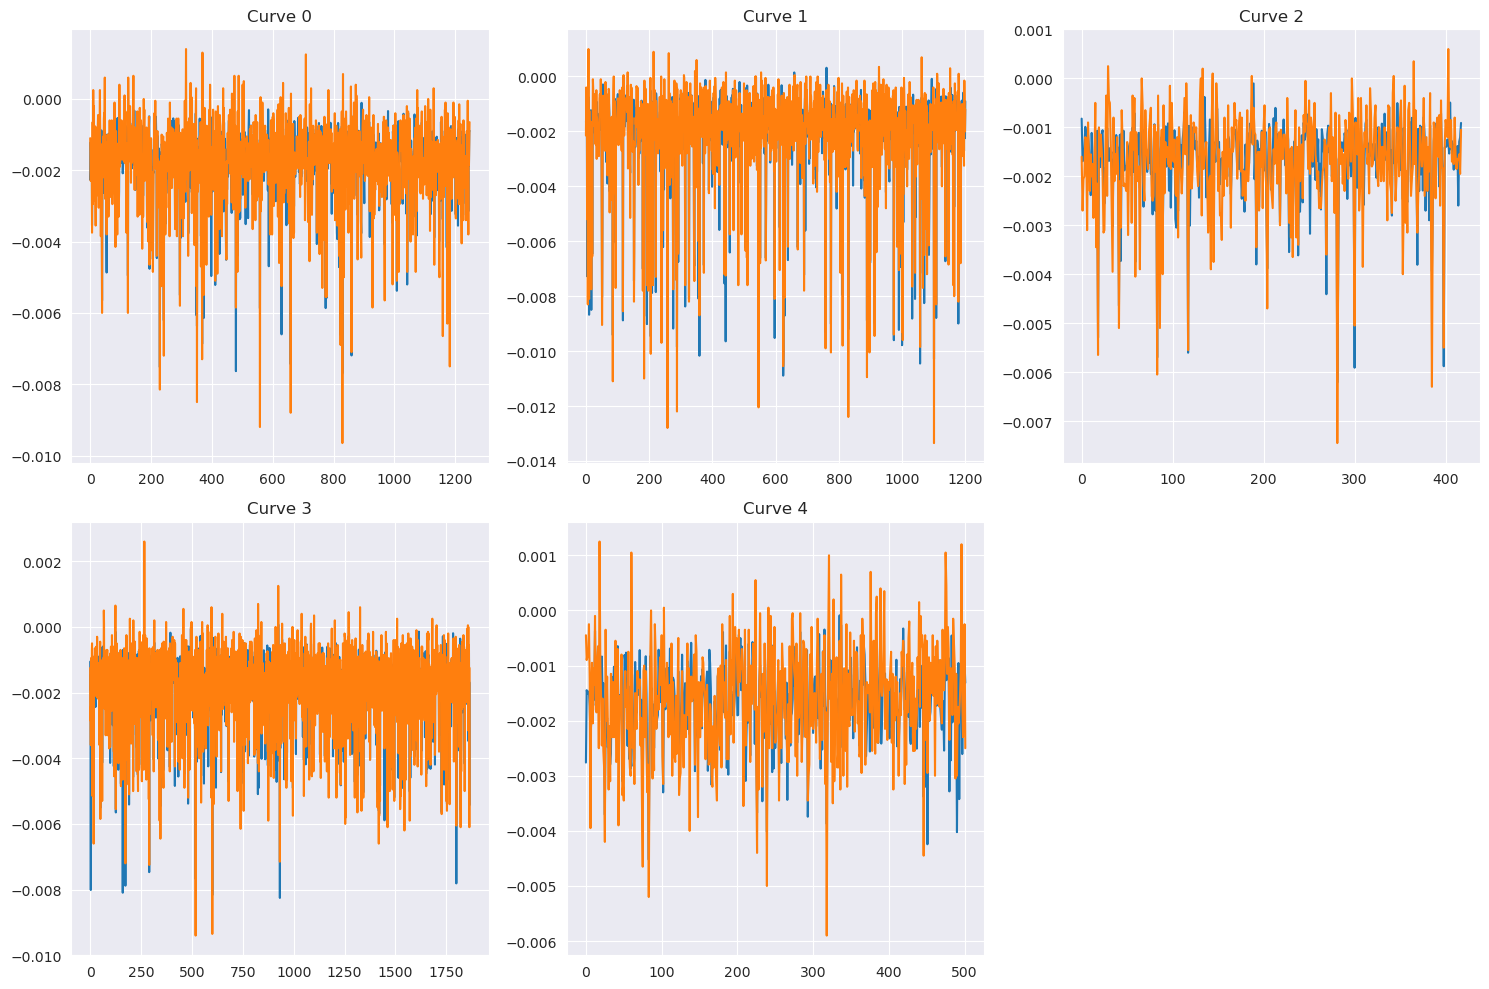

In [141]:
# Creating a 2x3 grid plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plotting in the first five subplots
axs[0, 0].plot(pred_list[0])
axs[0, 0].plot(y_test_list[0].reset_index(drop=True))
axs[0, 0].set_title('Curve 0')

axs[0, 1].plot(pred_list[1])
axs[0, 1].plot(y_test_list[1].reset_index(drop=True))
axs[0, 1].set_title('Curve 1')

axs[0, 2].plot(pred_list[2])
axs[0, 2].plot(y_test_list[2].reset_index(drop=True))
axs[0, 2].set_title('Curve 2')

axs[1, 0].plot(pred_list[3])
axs[1, 0].plot(y_test_list[3].reset_index(drop=True))
axs[1, 0].set_title('Curve 3')

axs[1, 1].plot(pred_list[4])
axs[1, 1].plot(y_test_list[4].reset_index(drop=True))
axs[1, 1].set_title('Curve 4')

# Leaving the last plot empty
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

# .plot()
# (rolling_mean_segments[1]["total_load"]/100).plot()

In [57]:
mae_list

[0.0005653286454635121,
 0.0005937277804003788,
 0.0005585440314299793,
 0.0005437335527249048,
 0.0006325777682239]

## Using only categorical values

In [58]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from itertools import product

# Parameters

topk = 20
segment_idxs = list(range(len(valid_bool_data_list)))
feat_sel_methods = ["p-value", "mi", "iv"]
parameters = list(product(segment_idxs, feat_sel_methods))

In [59]:
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

mae_df = pd.DataFrame(index=segment_idxs)

for segment_idx, feat_sel_method in parameters:
    if (feat_sel_method=="iv") or (feat_sel_method=="mi"):
        selected_categorical_variables = list(all_dfs_results_list[segment_idx].sort_values(feat_sel_method, ascending=False)[feat_sel_method][:topk].index)
    else:
        selected_categorical_variables = list(all_dfs_results_list[segment_idx].sort_values(feat_sel_method, ascending=True)[feat_sel_method][:topk].index)
    all_data = valid_bool_data_list[segment_idx]
    best_data = valid_bool_data_list[segment_idx][selected_categorical_variables]
    y = all_data["total_vol_diff"].copy()
    X = best_data.copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lgbm = LGBMRegressor(n_estimators=100)
    lgbm.fit(X_train, y_train)
    pred = lgbm.predict(X_test)
    mae = mean_absolute_error(pred, y_test)
    mae_df.loc[segment_idx, feat_sel_method] = mae

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 3245, number of used features: 20
[LightGBM] [Info] Start training from score -0.001795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [60]:
mae_df.mean()

p-value    0.000832
mi         0.000842
iv         0.000783
dtype: float64

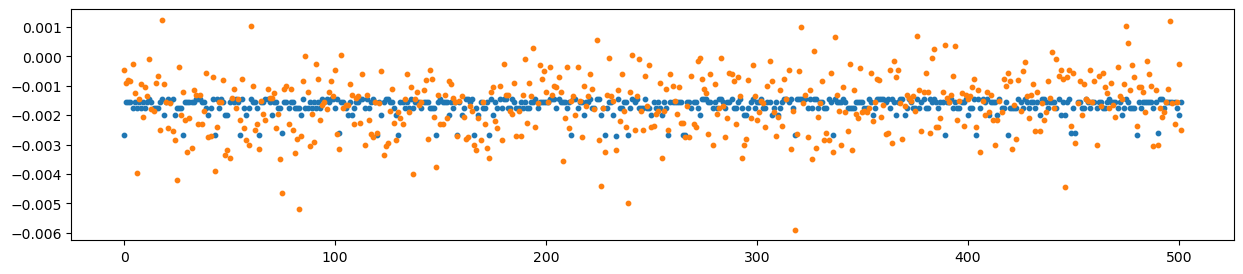

In [61]:
plt.figure(figsize=(15, 3))
plt.scatter(range(len(pred)), pred, s=10)
plt.scatter(range(len(pred)), y_test.reset_index(drop=True), s=10)

## Combine continuous and categorical values

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Neural Network
class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, 20)  # 20 outputs
        self.fc2 = nn.Linear(20, 20) # 20 inputs, 20 outputs
        self.fc3 = nn.Linear(20, 1)  # 10 inputs, 1 output (vol_diff)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def net_pipeline(X_train, y_train, X_test, y_test, epochs):
    net = Net(X_train.shape[1])

    # Define the Loss Function and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Example Data (you will replace this with your actual data)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convert X to a PyTorch tensor
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Convert y to a PyTorch tensor
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convert X to a PyTorch tensor
    inputs = X_train_tensor
    targets = y_train_tensor

    # Training the Network
    for epoch in range(epochs):  # number of times to loop over the dataset
        optimizer.zero_grad()   # zero the parameter gradients
        outputs = net(inputs)   # forward pass
        loss = criterion(outputs, targets) # calculate the loss
        loss.backward()         # backward pass
        optimizer.step()        # optimize

        if epoch % 10 == 0:    # print every 100 epochs
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    with torch.no_grad():
        test_input = X_test_tensor # Example voltage input
        predicted = net(test_input)
        mae = mean_absolute_error(y_test, predicted)
    return mae

In [62]:
bool_data_segments = []
original_segments = []
continuous_data_segments = []


for segment in segments:
    # Create a numerical index for grouping
    numeric_data = segment.select_dtypes(include=['number']).copy()
    mask = segments[0].columns.str.startswith("dI")
    bool_columns = segments[0].columns[mask]
    bool_data = segment.loc[:, bool_columns]
    numeric_data.loc[:numeric_data.shape[0]-2, "total_vol_diff"] = numeric_data["total_vol"].diff().values[1:]

    rolling_mean = numeric_data.rolling(100).mean()
    rolling_mean.dropna(inplace=True)

    # Find monotonically decreasing segment
    tmp = rolling_mean.copy()
    mono_dec_new_segment = pd.DataFrame(columns=tmp.columns)
    min_value = tmp.loc[tmp.index[0], "total_vol"]
    for idx, row in tmp.iterrows():
        if row["total_vol"] < min_value:
            mono_dec_new_segment.loc[idx] = row
            min_value = row["total_vol"]

    bool_data = bool_data.loc[mono_dec_new_segment.index, :]
    bool_data.dropna(inplace=True)
    bool_data = bool_data.astype(int)
    bool_data["total_vol_diff"] = mono_dec_new_segment["total_vol_diff"]
    mono_dec_new_segment = mono_dec_new_segment.loc[bool_data.index, :]
    bool_data.reset_index(drop=True, inplace=True)
    mono_dec_new_segment.reset_index(drop=True, inplace=True)
    bool_data_segments.append(bool_data)
    continuous_data_segments.append(mono_dec_new_segment)

In [63]:
# Remove bool data that is all false or all true
count_nonzero_list = []
valid_bool_data_list = []
for bool_data in bool_data_segments:
    count_nonzero = pd.DataFrame(data = np.zeros((2, len(bool_data_segments[0].columns))), index=['zero', 'nonzero'], columns=bool_data_segments[0].columns)
    n_rows = len(bool_data)
    for i in bool_data.columns:
        try:
            n_zero = bool_data[i].value_counts()[0]
            n_nonzero = n_rows - n_zero
            count_nonzero[i].iloc[0] = n_zero
            count_nonzero[i].iloc[1] = n_nonzero
        except:
            pass
    mask = (count_nonzero.loc["nonzero"]!=0) & (count_nonzero.loc["zero"]!=0)
    nonzero_columns = count_nonzero.loc["nonzero"][mask].index
    valid_bool_data_list.append(bool_data[nonzero_columns])

In [64]:
for i in range(len(continuous_data_segments)):
    print(continuous_data_segments[i].shape)
    print(valid_bool_data_list[i].shape)

(4057, 309)
(4057, 32)
(5955, 309)
(5955, 63)
(2089, 309)
(2089, 27)
(9287, 309)
(9287, 99)
(2510, 309)
(2510, 44)


In [72]:
from itertools import product

# We will use only the monotonically decreasing segments cuz increasing fuel values don't make sense
segment_idxs = list(range(len(continuous_data_segments)))
continuouts_feat_sel_methods = ["corr", "rfr", "gbr", "combined"]
topk_continuous = 20

# Categorical Parameters
categorical_feat_sel_methods = ["p-value", "mi", "iv"]
parameters = list(product(segment_idxs, continuouts_feat_sel_methods, categorical_feat_sel_methods))
topk_categorical = 2

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

lgbm_mae_df = pd.DataFrame(index=segment_idxs)
net_mae_df = pd.DataFrame(index=segment_idxs)

for segment_idx, continuous_feat_sel_method, categorical_feat_sel_method in parameters:
    if (continuous_feat_sel_method=="corr"):
        corr = mono_corrs_df.loc[:, f"corr{segment_idx}"]
        selected_negative_features = list(corr.sort_values()[:topk_continuous].index)
        selected_positive_features = list(corr.sort_values(ascending=False)[:topk_continuous].index)
        selected_features_continuous = set(selected_negative_features+selected_positive_features)
    elif continuous_feat_sel_method=="rfr":
        selected_features_continuous = selected_features_rf
    elif continuous_feat_sel_method=="gbr":
        selected_features_continuous = selected_features_gbr
    elif continuous_feat_sel_method=="combined":
        selected_features_continuous = selected_features_continuous_list[segment_idx]
    if "total_vol_diff" in selected_features_continuous:
        selected_features_continuous.remove("total_vol_diff")

    if (categorical_feat_sel_method=="iv") or (categorical_feat_sel_method=="mi"):
        selected_categorical_variables = list(all_dfs_results_list[segment_idx].sort_values(categorical_feat_sel_method, ascending=False)[categorical_feat_sel_method][:topk_categorical].index)
    else:
        selected_categorical_variables = list(all_dfs_results_list[segment_idx].sort_values(categorical_feat_sel_method, ascending=True)[categorical_feat_sel_method][:topk_categorical].index)
    all_data = valid_bool_data_list[segment_idx]
    best_data = valid_bool_data_list[segment_idx][selected_categorical_variables]
    y = all_data["total_vol_diff"].values.copy()
    X_categorical = best_data.copy()

    segment = continuous_data_segments[segment_idx]
    # Drop all zero columns
    nonzero_columns = segment.loc[:, (segment!=0).any(axis=0)].copy()
    nonzero_columns.drop("total_vol_diff", inplace=True, axis=1)
    try:
        X_continuous = nonzero_columns[selected_features_continuous].copy()
    except Exception as e:
        print(e)
        continue

    scaler = StandardScaler()
    X_continuous = scaler.fit_transform(X_continuous)

    X = np.hstack((X_continuous, X_categorical))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lgbm = LGBMRegressor(n_estimators=100)
    lgbm.fit(X_train, y_train)
    pred = lgbm.predict(X_test)
    mae = mean_absolute_error(pred, y_test)
    lgbm_mae_df.loc[segment_idx, f"{continuous_feat_sel_method}+{categorical_feat_sel_method}"] = mae

    mae = net_pipeline(X_train, y_train.reshape(-1,1), X_test, y_test.reshape(-1,1), epochs=100)
    net_mae_df.loc[segment_idx, f"{continuous_feat_sel_method}+{categorical_feat_sel_method}"] = mae

/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5879
[LightGBM] [Info] Number of data points in the train set: 3245, number of used features: 41
[LightGBM] [Info] Start training from score -0.001795
Epoch 0, Loss: 0.024530697613954544
Epoch 10, Loss: 0.004246616270393133
Epoch 20, Loss: 0.0016450625844299793
Epoch 30, Loss: 0.0008399977814406157
Epoch 40, Loss: 0.00031940071494318545
Epoch 50, Loss: 0.00020651471277233213
Epoch 60, Loss: 0.00012681930093094707
Epoch 70, Loss: 8.905066351871938e-05
Epoch 80, Loss: 6.322398985503241e-05
Epoch 90, Loss: 4.8705143854022026e-05


/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5879
[LightGBM] [Info] Number of data points in the train set: 3245, number of used features: 41
[LightGBM] [Info] Start training from score -0.001795
Epoch 0, Loss: 0.03227094188332558
Epoch 10, Loss: 0.011900576762855053
Epoch 20, Loss: 0.004294305108487606
Epoch 30, Loss: 0.0020250771194696426
Epoch 40, Loss: 0.0007755847764201462
Epoch 50, Loss: 0.0002893957425840199
Epoch 60, Loss: 0.00013412570115178823
Epoch 70, Loss: 9.082406904781237e-05
Epoch 80, Loss: 7.735894905636087e-05
Epoch 90, Loss: 6.0502065025502816e-05


/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5879
[LightGBM] [Info] Number of data points in the train set: 3245, number of used features: 41
[LightGBM] [Info] Start training from score -0.001795
Epoch 0, Loss: 0.006851044483482838
Epoch 10, Loss: 0.0009191759745590389
Epoch 20, Loss: 0.0003116026637144387
Epoch 30, Loss: 0.00016928168770391494
Epoch 40, Loss: 9.104171476792544e-05
Epoch 50, Loss: 5.873204645467922e-05
Epoch 60, Loss: 3.91440698876977e-05
Epoch 70, Loss: 3.027203456440475e-05
Epoch 80, Loss: 2.4211696654674597e-05
Epoch 90, Loss: 1.962841815839056e-05
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnoc

/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


Epoch 60, Loss: 3.664767064037733e-05
Epoch 70, Loss: 2.8719123292830773e-05
Epoch 80, Loss: 2.381241756665986e-05
Epoch 90, Loss: 2.0491748728090897e-05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5582
[LightGBM] [Info] Number of data points in the train set: 4764, number of used features: 41
[LightGBM] [Info] Start training from score -0.002122
Epoch 0, Loss: 0.049608390778303146
Epoch 10, Loss: 0.010984987020492554
Epoch 20, Loss: 0.0025329510681331158
Epoch 30, Loss: 0.0009383424767293036


/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


Epoch 40, Loss: 0.0006493214750662446
Epoch 50, Loss: 0.0003651069710031152
Epoch 60, Loss: 0.00025023031048476696
Epoch 70, Loss: 0.00019105803221464157
Epoch 80, Loss: 0.00015259426436387002
Epoch 90, Loss: 0.00012563537165988237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5582
[LightGBM] [Info] Number of data points in the train set: 4764, number of used features: 41
[LightGBM] [Info] Start training from score -0.002122
Epoch 0, Loss: 0.0070397257804870605
Epoch 10, Loss: 0.0006902865716256201
Epoch 20, Loss: 0.0003331870539113879
Epoch 30, Loss: 0.00016256868548225611


/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


Epoch 40, Loss: 8.73619137564674e-05
Epoch 50, Loss: 5.4001797252567485e-05
Epoch 60, Loss: 4.298380736145191e-05
Epoch 70, Loss: 3.6313522286945954e-05
Epoch 80, Loss: 3.0485814932035282e-05
Epoch 90, Loss: 2.6847688786801882e-05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7007
[LightGBM] [Info] Number of data points in the train set: 4764, number of used features: 32
[LightGBM] [Info] Start training from score -0.002122
Epoch 0, Loss: 0.0069234296679496765
Epoch 10, Loss: 0.0012388763716444373
Epoch 20, Loss: 0.00048587669152766466
Epoch 30, Loss: 0.0003023318131454289
Epoch 40, Loss: 0.0001748801878420636
Epoch 50, Loss: 0.00012992015399504453
Epoch 60, Loss: 9.658500493969768e-05
Epoch 70, Loss: 7.731033838354051e-05
Epoch 80, Loss: 6.380627019098029e-05
Epoch 90, Loss: 5.4082705901237205e-05
[LightGBM] [Info] Auto-choosing col-wise mult

/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()
/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


Epoch 0, Loss: 0.03190190717577934
Epoch 10, Loss: 0.0018997316947206855
Epoch 20, Loss: 0.0007546311826445162
Epoch 30, Loss: 0.0002282458881381899
Epoch 40, Loss: 0.00019500861526466906
Epoch 50, Loss: 0.0001032268992275931
Epoch 60, Loss: 8.294946746900678e-05
Epoch 70, Loss: 6.350533658405766e-05
Epoch 80, Loss: 5.293154754326679e-05
Epoch 90, Loss: 4.5577929995488375e-05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7949
[LightGBM] [Info] Number of data points in the train set: 1671, number of used features: 41
[LightGBM] [Info] Start training from score -0.001739
Epoch 0, Loss: 0.029237179085612297
Epoch 10, Loss: 0.005090663675218821
Epoch 20, Loss: 0.0010318089043721557
Epoch 30, Loss: 0.0005650647217407823
Epoch 40, Loss: 0.0002093634393531829
Epoch 50, Loss: 0.00014518034004140645
Epoch 60, Loss: 0.0001026668687700294
Epoch 70, Loss:

/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


Epoch 40, Loss: 4.1879502532538027e-05
Epoch 50, Loss: 3.011089575011283e-05
Epoch 60, Loss: 2.2244597857934423e-05
Epoch 70, Loss: 1.7220185327460058e-05
Epoch 80, Loss: 1.411609355272958e-05
Epoch 90, Loss: 1.193002663057996e-05
"['aIKnockKnockIntensityCylinderA07_x', 'aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA07_x', 'aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA07_x', 'aIKnockKnockIntensityCylinderA05_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
"['aIKnockKnockIntensityCylinderA05_x', 'aIKnockKnockIntensityCylinderA07_x', 'aIPilotFOPressureControl_x'] not in index"
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_

/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


Epoch 0, Loss: 0.03985736519098282
Epoch 10, Loss: 0.0106935640797019
Epoch 20, Loss: 0.002268778393045068
Epoch 30, Loss: 0.0012790430337190628
Epoch 40, Loss: 0.0007238299585878849
Epoch 50, Loss: 0.00034850017982535064
Epoch 60, Loss: 0.00021952316456008703
Epoch 70, Loss: 0.00013059638149570674
Epoch 80, Loss: 9.074651461560279e-05
Epoch 90, Loss: 6.760682299500331e-05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4985
[LightGBM] [Info] Number of data points in the train set: 7429, number of used features: 41
[LightGBM] [Info] Start training from score -0.001809


/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


Epoch 0, Loss: 0.007638571783900261
Epoch 10, Loss: 0.0011282799532637
Epoch 20, Loss: 0.0005002742982469499
Epoch 30, Loss: 0.00017965902225114405
Epoch 40, Loss: 9.112400584854186e-05
Epoch 50, Loss: 7.680459384573624e-05
Epoch 60, Loss: 5.4458214435726404e-05
Epoch 70, Loss: 4.292416633688845e-05
Epoch 80, Loss: 3.3515254472149536e-05
Epoch 90, Loss: 2.6258961952407844e-05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4985
[LightGBM] [Info] Number of data points in the train set: 7429, number of used features: 41
[LightGBM] [Info] Start training from score -0.001809


/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


Epoch 0, Loss: 0.0009990223916247487
Epoch 10, Loss: 0.00011145978351123631
Epoch 20, Loss: 4.255005842423998e-05
Epoch 30, Loss: 2.5794151952140965e-05
Epoch 40, Loss: 1.208875073643867e-05
Epoch 50, Loss: 8.765950951783452e-06
Epoch 60, Loss: 6.834784016973572e-06
Epoch 70, Loss: 5.76882030145498e-06
Epoch 80, Loss: 5.2404161579033826e-06
Epoch 90, Loss: 4.827711563848425e-06
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7003
[LightGBM] [Info] Number of data points in the train set: 7429, number of used features: 32
[LightGBM] [Info] Start training from score -0.001809
Epoch 0, Loss: 0.0136247044429183
Epoch 10, Loss: 0.002885288791731
Epoch 20, Loss: 0.0009312391048297286
Epoch 30, Loss: 0.0004727806954178959
Epoch 40, Loss: 0.0003117543237749487
Epoch 50, Loss: 0.0002112337970174849
Epoch 60, Loss: 0.0001566682185512036
Epoch 70, Loss: 0.0

/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()
/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


Epoch 0, Loss: 0.04641619697213173
Epoch 10, Loss: 0.004186720587313175
Epoch 20, Loss: 0.00128604331985116
Epoch 30, Loss: 0.000826559669803828
Epoch 40, Loss: 0.00018631634884513915
Epoch 50, Loss: 0.00015234255988616496
Epoch 60, Loss: 7.950101280584931e-05
Epoch 70, Loss: 6.630210555158556e-05
Epoch 80, Loss: 5.111092468723655e-05
Epoch 90, Loss: 4.4288750359555706e-05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6695
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 41
[LightGBM] [Info] Start training from score -0.001672
Epoch 0, Loss: 0.018179288133978844
Epoch 10, Loss: 0.0007795360288582742
Epoch 20, Loss: 0.0012096530990675092
Epoch 30, Loss: 0.0001874894369393587
Epoch 40, Loss: 0.00019786252232734114
Epoch 50, Loss: 6.247447163332254e-05
Epoch 60, Loss: 4.405601794132963e-05
Epoch 70, Loss: 3

/tmp/ipykernel_2023816/2793864107.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_continuous = nonzero_columns[selected_features_continuous].copy()


Epoch 10, Loss: 0.0021400193218141794
Epoch 20, Loss: 0.002534393221139908
Epoch 30, Loss: 0.0004453763831406832
Epoch 40, Loss: 0.0004028048424515873
Epoch 50, Loss: 0.0002098244585795328
Epoch 60, Loss: 0.00014018910587765276
Epoch 70, Loss: 0.00010542641393840313
Epoch 80, Loss: 8.496340160490945e-05
Epoch 90, Loss: 7.12921901140362e-05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6974
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 31
[LightGBM] [Info] Start training from score -0.001672
Epoch 0, Loss: 0.010994304902851582
Epoch 10, Loss: 0.0018628498073667288
Epoch 20, Loss: 0.000684013997670263
Epoch 30, Loss: 0.00037516720476560295
Epoch 40, Loss: 0.00018816025112755597
Epoch 50, Loss: 0.00011848314170492813
Epoch 60, Loss: 9.151776612270623e-05
Epoch 70, Loss: 6.960153405088931e-05
Epoch 80, Lo

KeyboardInterrupt: 

In [130]:
print(lgbm_mae_df.mean())
print(net_mae_df.mean())
print(np.mean(mae_list))

corr+p-value        0.000589
corr+mi             0.000589
corr+iv             0.000590
combined+p-value    0.000579
combined+mi         0.000577
combined+iv         0.000577
rfr+p-value         0.000594
rfr+mi              0.000595
rfr+iv              0.000594
gbr+p-value         0.000592
gbr+mi              0.000592
gbr+iv              0.000593
dtype: float64
corr+p-value        0.005753
corr+mi             0.004188
corr+iv             0.004854
combined+p-value    0.003750
combined+mi         0.004777
combined+iv         0.007573
rfr+p-value         0.007442
rfr+mi              0.010595
rfr+iv              0.006866
gbr+p-value         0.007425
gbr+mi              0.006034
gbr+iv              0.005010
dtype: float64
0.000578782355648535


In [115]:
nonzero_columns.columns

Index(['Unnamed: 0_x', 'aIAirTemperatureTCInlet_x',
       'aIChargeAirPressureEngineInlet_x', 'aIChargeAirSetpointBarMPa_x',
       'aIChargeAirTemperatureEngineInlet_x', 'aICounterStarts_x',
       'aICrankcasePressure_x', 'aIDVTControlAirPressure_x', 'aIEngineLoad_x',
       'aIEngineLoadPercent_x',
       ...
       'aIRemainingTimeForStartBlockDueToPT621Low_y',
       'aIRemainingTimeForStartBlockDueToPT622Low_y',
       'aIStartingAirPressureEngineInlet_y', 'aITCSpeedABank_y',
       'aIThrustBearingTemperature1_y',
       'aITimeRemainingForNextCyclicSlowTurningMin_y',
       'aIWasteGateValvePositionCommand_y', 'dateTime_y', 'total_load',
       'total_vol'],
      dtype='object', length=203)

In [104]:
X_train

array([[nan, nan, nan, ..., nan,  0.,  0.],
       [nan, nan, nan, ..., nan,  0.,  0.],
       [nan, nan, nan, ..., nan,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan,  0.,  0.],
       [nan, nan, nan, ..., nan,  0.,  0.],
       [nan, nan, nan, ..., nan,  0.,  0.]])

In [102]:
net_mae_df

,corr+p-value
0,0.005664
1,NaN
2,NaN
3,NaN
4,NaN


In [99]:
np.mean(mae_list)

0.000578782355648535

In [100]:
X_categorical.values.shape

(4057, 2)

In [70]:
np.hstack((X_continuous, X_categorical)).shape

(2510, 50)